In [188]:
import arivale_data_interface as adi
from analytics.io.genotype.wgs import Wgs
import numpy, pandas, glob, random, seaborn, re, matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from matplotlib.lines import Line2D
from matplotlib import colors
import sklearn.linear_model
from sklearn.model_selection import KFold
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats import multitest
from pyplink import PyPlink
import rpy2.robjects as R
from rpy2.robjects import numpy2ri, pandas2ri
numpy2ri.activate()
pandas2ri.activate()
matplotlib.rcParams['figure.dpi'] = 300

In [189]:
# define cohort and taxonomy level
cohort = 'both'
taxa_level = 'genus'
bmi_or_not = 'bmi'
classification = 'rdp'
classification_method = classification + '_classification'

In [190]:
def rename_numerical_id(ID):
    if re.match("^[0-9]", str(ID)) != None:
        return 'X' + str(ID)
    else:
        return str(ID)
    
def gxe_analysis(non_gxe_formula, gxe_formula, df):
    reg_fit = ols(non_gxe_formula, df).fit()
    gxe_fit = ols(gxe_formula, df).fit()
    anova_pval = anova_lm(reg_fit, gxe_fit).loc[1,'Pr(>F)']
    return reg_fit.rsquared, gxe_fit.rsquared, gxe_fit.params['gxe'], anova_pval

def run_gxe(rsid, metab, microbe, genotype, geno_pheno_covar):
    temp_geno = pandas.DataFrame([])
    temp_snp_df = pandas.DataFrame(genotype.get_geno_marker(rsid), index = sample_ids, columns = [rsid])
    temp_geno = temp_geno.join(temp_snp_df, how='outer')

    temp_geno_pheno_covar = pheno_covar_merged[[metab, microbe] + covariates].join(temp_geno, how = 'inner').dropna()
    temp_geno_pheno_covar['gxe'] = temp_geno_pheno_covar[rsid] * temp_geno_pheno_covar[microbe]

    reg_formula = metab + ' ~ ' + ' + '.join(q_covar + rename_c_covar + [rsid, microbe])
    gxe_formula = metab + ' ~ ' + ' + '.join(q_covar + rename_c_covar + [rsid, microbe, 'gxe'])

    reg_r_sq, gxe_r_sq, gxe_beta, gxe_pval = gxe_analysis(reg_formula, gxe_formula, temp_geno_pheno_covar)


# load phenotype 

In [208]:
# load pheno
micro_metab_unadj = pandas.read_csv('./joint_pheno/{0}_{1}_{2}_micro_metab_unadj.pheno'.format(cohort, taxa_level, classification), index_col = [0,1])
micro_metab_covar = pandas.read_csv('./joint_pheno/{0}_{1}_{2}_micro_metab_unadj.covar'.format(cohort, taxa_level, classification), index_col = [0,1])
pheno_covar_merged_full = micro_metab_unadj.join(micro_metab_covar)
pheno_covar_merged_full.index = pheno_covar_merged_full.index.droplevel(0)
pheno_covar_merged_full.columns = [rename_numerical_id(col) for col in pheno_covar_merged_full.columns]

# define covariates
q_covar = ['age','age_sq','sex_age','sex_age_sq','PC1','PC2','PC3','PC4','PC5', 'bmi']
c_covar = ['sex','batch']
rename_c_covar = ['C({0})'.format(covar) for covar in c_covar]
covariates = q_covar + c_covar

form_covar = ['scale(age)', 'I(scale(age)**2)', 'PC1','PC2','PC3','PC4','PC5', 'bmi']
int_covar = ['scale(age)*C(sex)', 'I(scale(age)**2)*C(sex)']
form_covar = form_covar + rename_c_covar + int_covar

# load association
micro_metab_assoc = pandas.read_csv('./assoc_results/{0}_sig_metab_{1}_{2}_classification_lasso.csv'.format(cohort, taxa_level, classification))
micro_metab_assoc['metabolite_id'] = [rename_numerical_id(identifier) for identifier in micro_metab_assoc['metabolite_id']]
micro_metab_assoc['tax_id'] = [rename_numerical_id(identifier) for identifier in micro_metab_assoc['tax_id']]
sig_metabolite = micro_metab_assoc['metabolite_id'].unique()
print(len(sig_metabolite))

# get metadata
metabolite_metadata = pandas.read_csv('./input_pheno/no_micro_metab_10202019.pheno.metadata', sep = '\t', dtype=str)
metabolite_metadata = metabolite_metadata.groupby('metabolite_id').first()[['metabolite','super_pathway']]
metabolite_metadata.index = [rename_numerical_id(identifier) for identifier in metabolite_metadata.index]
metabolite_metadata_dict = metabolite_metadata['metabolite'].to_dict()
metabolite_super_pathway_dict = metabolite_metadata['super_pathway'].to_dict()

taxa_metadata = pandas.read_csv('./joint_pheno/{0}_{1}.metadata'.format(taxa_level, classification_method), dtype=str, sep = '\t')
taxa_metadata = taxa_metadata.set_index('tax_id')
taxa_metadata.index = [rename_numerical_id(identifier) for identifier in taxa_metadata.index]
genus_metadata_dict = taxa_metadata['taxonomy'].str.split(';').str.get(-1).to_dict()

146


# get genotype

In [160]:
genotype = PyPlink('./input_bed/all_chr/all_genomes_09112019_all_chr')
# genotype = PyPlink('/homedir/notebooks-cheng/mgwas/data/snp_query_03182019/final_merged/bed_files/all_chr/merged_metabolome_inds_biallelic_variants_all_chr')
sample_ids = genotype.get_fam().iid.values

In [209]:
snp_list = '/homedir/notebooks-cheng/mr_project/gxe/validate_gwas/clumped_variants/metab/fastgwa/clumped_10perc_second_pass_list.txt'
sig_metab_assoc = pandas.read_csv(snp_list, sep = '\t', header = None)
sig_metab_assoc.columns = ['rsid', 'Phenotype']

# subset to phenotypes that have microbiome associations
sig_metab_assoc = sig_metab_assoc[sig_metab_assoc['Phenotype'].isin(micro_metab_assoc['metabolite_id'].values)]
sig_metab_assoc = sig_metab_assoc[~sig_metab_assoc['Phenotype'].str.contains('X99')]
print(len(sig_metab_assoc['Phenotype'].unique()))

146


# run GxE

In [235]:
pheno_covar_merged = pheno_covar_merged_full.copy()

gxe_results = []
rev_rsid_map = {}
for metab in sig_metab_assoc['Phenotype'].unique():
    rsids = sig_metab_assoc.loc[sig_metab_assoc['Phenotype'] == metab, 'rsid'].values
    microbes = list(micro_metab_assoc.loc[micro_metab_assoc['metabolite_id'] == metab, 'tax_id'].values)
    
    print(metab, metabolite_metadata_dict[metab], f'# snps: {len(rsids)}', f'# bugs: {len(microbes)}')

    temp_geno = pandas.DataFrame([])
    rename_rsid = {}
    for rsid in rsids:
        rename_rsid.update({rsid:rsid.split(';')[0]})

        temp_snp_df = pandas.DataFrame(genotype.get_geno_marker(rsid), index = sample_ids, columns = [rsid])
        temp_geno = temp_geno.join(temp_snp_df, how='outer')
        temp_geno = temp_geno.rename(columns = rename_rsid)

    temp_geno_pheno_covar = pheno_covar_merged[[metab] + microbes + covariates].join(temp_geno, how = 'inner').dropna()

    for new_rsid in rename_rsid.values():
        temp_gxe_results = []
        
        gxe_terms = []
        for microbe in set(microbes):
            gxe_terms.append(new_rsid + ':' + microbe)

        try:
            assert (temp_geno_pheno_covar.groupby(new_rsid).count() > 30).all().all()
            n_alt_count = temp_geno_pheno_covar.groupby(new_rsid).count()
            n_alt_0 = n_alt_count.loc[0][0]
            n_alt_1 = n_alt_count.loc[1][0]
            n_alt_2 = n_alt_count.loc[2][0]
        except:
            continue
            
        no_gxe_formula = metab + ' ~ ' + ' + '.join(form_covar + [new_rsid] + microbes)
        gxe_formula = metab + ' ~ ' + ' + '.join(form_covar + [new_rsid] + microbes + gxe_terms)
        
        no_int_out = ols(no_gxe_formula, temp_geno_pheno_covar).fit()
        basline_rsq = no_int_out.rsquared
        
        int_out = ols(gxe_formula, temp_geno_pheno_covar).fit()
        int_rsq = int_out.rsquared
        gxe_betas = int_out.params.loc[gxe_terms]
        gxe_pvals = int_out.pvalues.loc[gxe_terms]

        for microbe in microbes:
            int_variable = new_rsid + ':' + microbe
            gxe_beta = gxe_betas.loc[int_variable]
            gxe_pval = gxe_pvals.loc[int_variable]
            temp_gxe_results.append([metab, microbe, new_rsid, gxe_beta, gxe_pval, basline_rsq, int_rsq, n_alt_0, n_alt_1, n_alt_2])

        if len(temp_gxe_results) > 0:
            temp_gxe_results_df = pandas.DataFrame(temp_gxe_results)
            temp_gxe_results_df.columns = ['metabolite_id','tax_id','rsid','gxe_beta','pval', 
                                           'baseline_rsq', 'gxe_rsq', 'n_alt_0', 'n_alt_1', 'n_alt_2']
            fdr_pass, adj_pval, sidack, bonff = statsmodels.stats.multitest.multipletests(temp_gxe_results_df['pval'].values, method='fdr_bh')
            temp_gxe_results_df['pass_fdr'] = fdr_pass
            temp_gxe_results_df['adj_pval'] = adj_pval
            gxe_results.append(temp_gxe_results_df)
gxe_results_df = pandas.concat(gxe_results)


X100000007 carnitine # snps: 1 # bugs: 2
X100000054 5-hydroxylysine # snps: 7 # bugs: 1
X100000096 4-guanidinobutanoate # snps: 2 # bugs: 1
X100000263 imidazole lactate # snps: 4 # bugs: 1
X100000406 ribitol # snps: 2 # bugs: 4
X100000616 1-stearoyl-2-arachidonoyl-GPI (18:0/20:4) # snps: 2 # bugs: 2
X100000774 phenyllactate (PLA) # snps: 2 # bugs: 2
X100000792 dehydroepiandrosterone sulfate (DHEA-S) # snps: 2 # bugs: 1
X100000963 homocitrulline # snps: 1 # bugs: 1
X100001006 N-acetylglycine # snps: 1 # bugs: 2
X100001055 isobutyrylcarnitine (C4) # snps: 5 # bugs: 7
X100001092 trigonelline (N'-methylnicotinate) # snps: 1 # bugs: 8
X100001150 propionylglycine # snps: 1 # bugs: 7
X100001193 adrenate (22:4n6) # snps: 1 # bugs: 1
X100001197 10-undecenoate (11:1n1) # snps: 1 # bugs: 1
X100001208 1-methyl-4-imidazoleacetate # snps: 1 # bugs: 1
X100001287 epiandrosterone sulfate # snps: 4 # bugs: 4
X100001300 alpha-hydroxyisovalerate # snps: 2 # bugs: 1
X100001403 5-acetylamino-6-amino-3-methy

In [236]:
gxe_fold_results_df = gxe_results_df.copy()
gxe_fold_results_annotated = gxe_fold_results_df.merge(metabolite_metadata, left_on = 'metabolite_id', right_index = True, how = 'left')
gxe_fold_results_annotated = gxe_fold_results_annotated.merge(taxa_metadata, left_on = 'tax_id', right_index = True, how = 'left')
gxe_fold_results_annotated['genus'] = gxe_fold_results_annotated['taxonomy'].str.split(';').str.get(-1)
gxe_fold_results_annotated['family'] = gxe_fold_results_annotated['taxonomy'].str.split(';').str.get(-2)
gxe_fold_results_annotated['super_pathway'] = list(map(metabolite_super_pathway_dict.get, gxe_fold_results_annotated['metabolite_id']))


In [237]:
sig_gxe_fold_results_annotated = gxe_fold_results_annotated[gxe_fold_results_annotated['pass_fdr'] == True]

In [239]:
min_count = 30
gxe_results_sig_abundant = sig_gxe_fold_results_annotated[(sig_gxe_fold_results_annotated['n_alt_0'] > min_count) & 
                                           (sig_gxe_fold_results_annotated['n_alt_1'] > min_count) & 
                                           (sig_gxe_fold_results_annotated['n_alt_2'] > min_count)]

gxe_results_sig_abundant.groupby(['rsid','metabolite','genus', 'metabolite_id', 'tax_id']).mean().sort_values('pval', ascending = True)

gxe_beta  \
rsid       metabolite                                   genus                        metabolite_id tax_id                                              
rs99780    arachidonate (20:4n6)                        Shannon alpha diversity      X229          alpha_div                                0.126514   
rs174564   1-palmitoyl-2-arachidonoyl-GPC (16:0/20:4n6) Shannon alpha diversity      X100008914    alpha_div                                0.081749   
rs4149056  glycodeoxycholate 3-sulfate                  g__Clostridium sensu stricto X100006642    d94ec785ef42d385e795f4b632348ab1_genus  -0.062712   
rs1077834  1-oleoyl-2-linoleoyl-GPE (18:1/18:2)*        g__Anaerotruncus             X100009078    X5e7ac536729db90d7a5a9058b740f7df_genus -0.050786   
rs62492368 N-acetyl-isoputreanine                       g__Butyrivibrio              X100020487    fa8736805c8e7480ae5346dcb2066e64_genus  -0.017692   
rs11045856 hexadecanedioate (C16-DC)                    g__Anaerovorax               X100001614    X05d22123919388ec62a90ab4908e537d_genus  0.051672   

                                                                                                                                                pval  \
rsid       metabolite                                   genus                        metabolite_id tax_id                                              
rs99780    arachidonate (20:4n6)                        Shannon alpha diversity      X229          alpha_div                                0.002553   
rs174564   1-palmitoyl-2-arachidonoyl-GPC (16:0/20:4n6) Shannon alpha diversity      X100008914    alpha_div                                0.002831   
rs4149056  glycodeoxycholate 3-sulfate                  g__Clostridium sensu stricto X100006642    d94ec785ef42d385e795f4b632348ab1_genus   0.004174   
rs1077834  1-oleoyl-2-linoleoyl-GPE (18:1/18:2)*        g__Anaerotruncus             X100009078    X5e7ac536729db90d7a5a9058b740f7df_genus  0.020886   
rs62492368 N-acetyl-isoputreanine                       g__Butyrivibrio              X100020487    fa8736805c8e7480ae5346dcb2066e64_genus   0.030297   
rs11045856 hexadecanedioate (C16-DC)                    g__Anaerovorax               X100001614    X05d22123919388ec62a90ab4908e537d_genus  0.043723   

                                                                                                                                            baseline_rsq  \
rsid       metabolite                                   genus                        metabolite_id tax_id                                                  
rs99780    arachidonate (20:4n6)                        Shannon alpha diversity      X229          alpha_div                                    0.126854   
rs174564   1-palmitoyl-2-arachidonoyl-GPC (16:0/20:4n6) Shannon alpha diversity      X100008914    alpha_div                                    0.177300   
rs4149056  glycodeoxycholate 3-sulfate                  g__Clostridium sensu stricto X100006642    d94ec785ef42d385e795f4b632348ab1_genus       0.145839   
rs1077834  1-oleoyl-2-linoleoyl-GPE (18:1/18:2)*        g__Anaerotruncus             X100009078    X5e7ac536729db90d7a5a9058b740f7df_genus      0.104624   
rs62492368 N-acetyl-isoputreanine                       g__Butyrivibrio              X100020487    fa8736805c8e7480ae5346dcb2066e64_genus       0.123823   
rs11045856 hexadecanedioate (C16-DC)                    g__Anaerovorax               X100001614    X05d22123919388ec62a90ab4908e537d_genus      0.102309   

                                                                                                                                             gxe_rsq  \
rsid       metabolite                                   genus                        metabolite_id tax_id                                              
rs99780    arachidonate (20:4n6)                        Shannon alpha diversity      X229          alpha_div                                0.134111   
r

In [240]:
temp_gxe_interest = gxe_results_sig_abundant[gxe_results_sig_abundant['pass_fdr'] == True].sort_values('pval').drop_duplicates()
temp_gxe_interest = temp_gxe_interest.reset_index(drop = True)

# plot

rs99780 arachidonate (20:4n6) Shannon alpha diversity


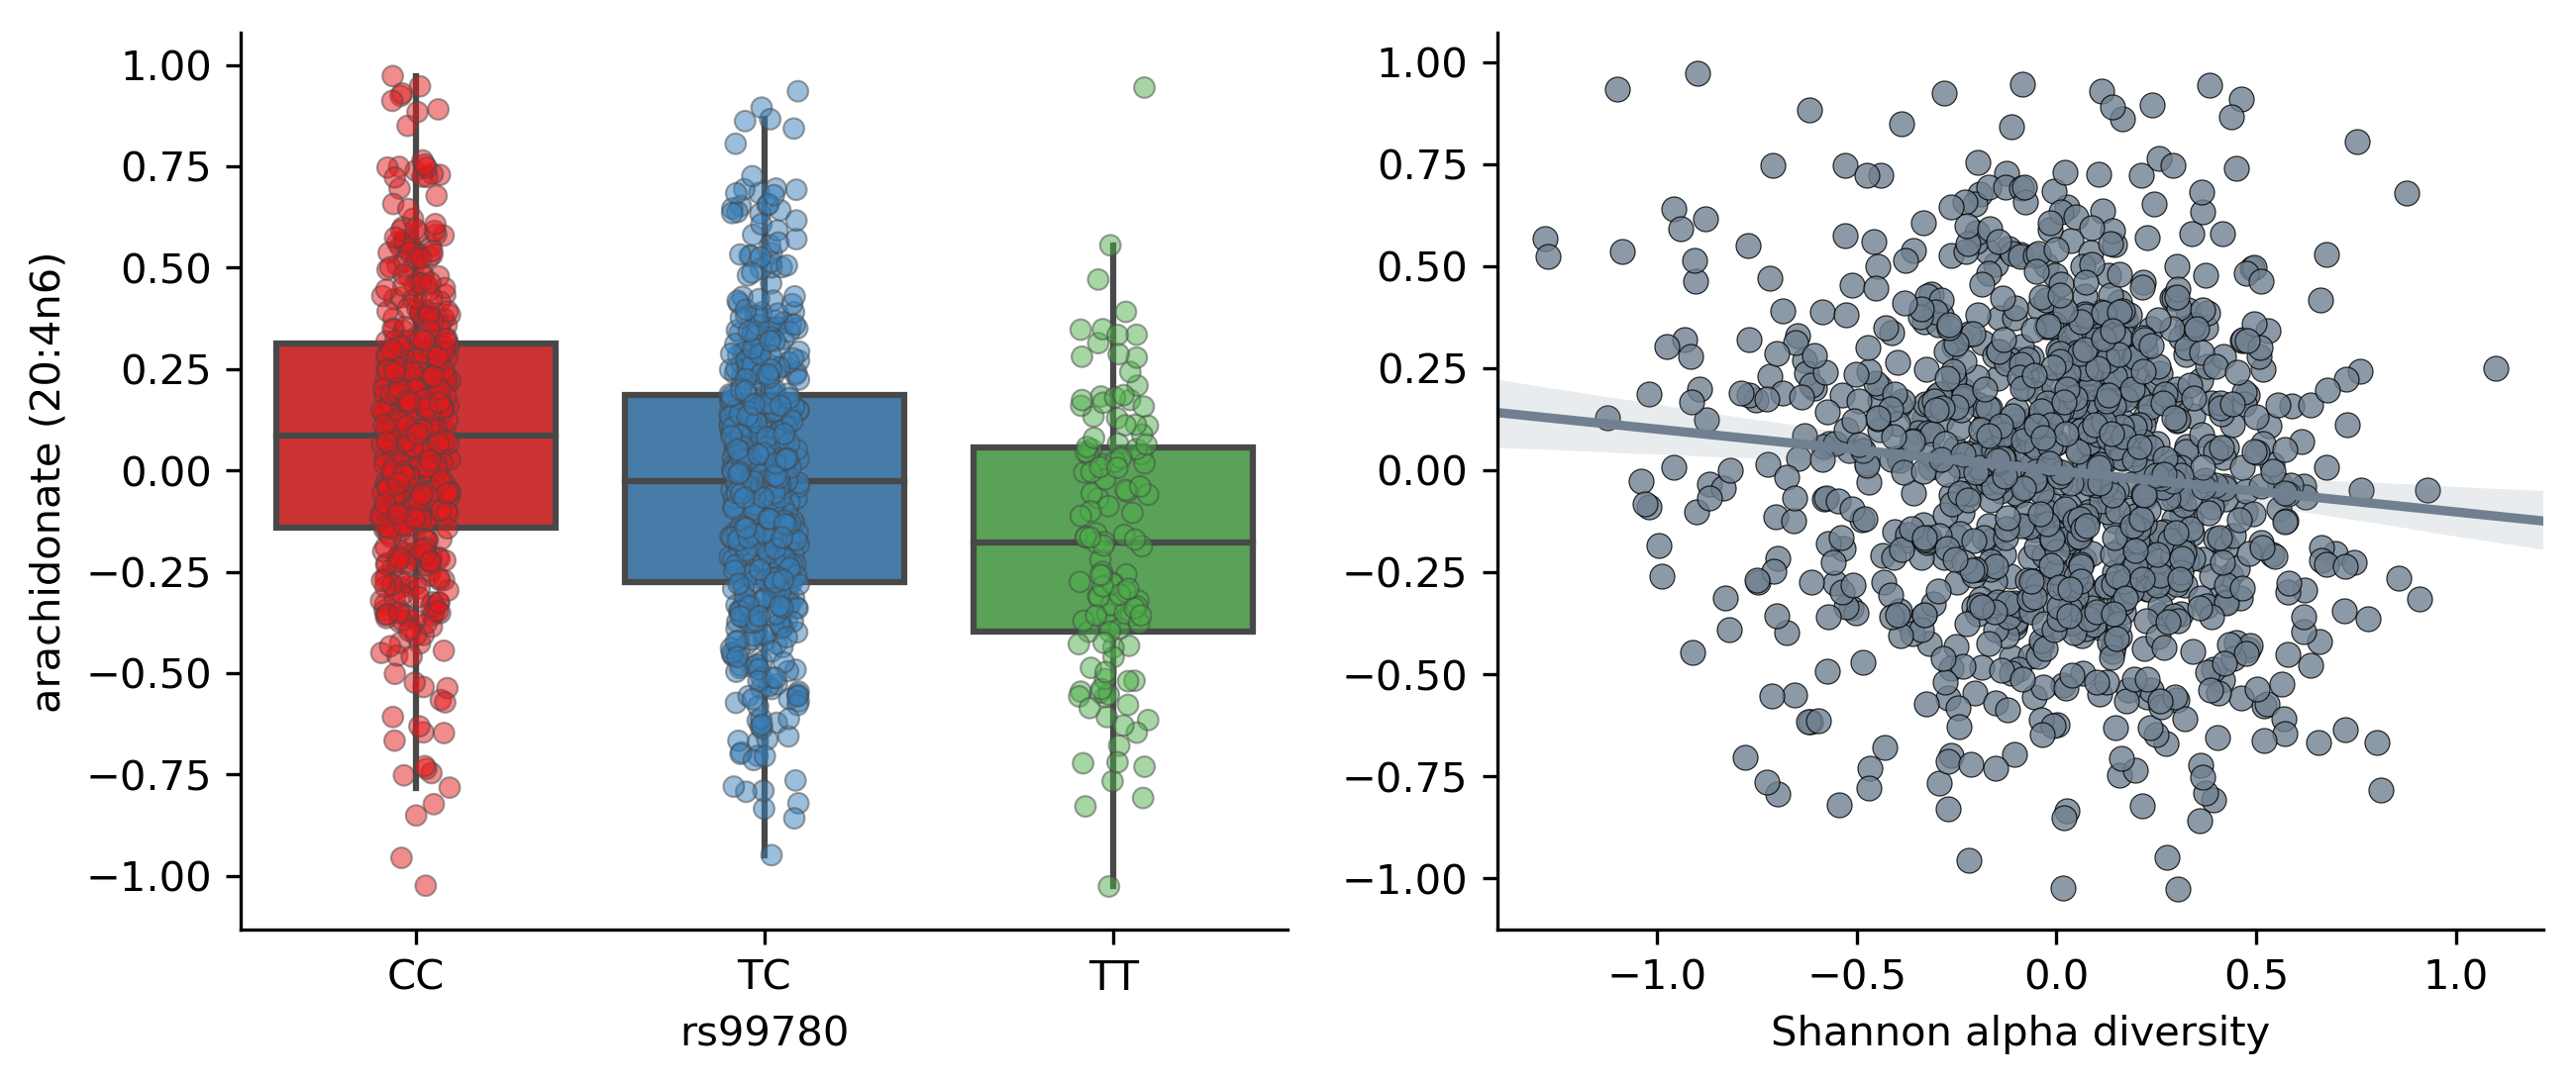

-0.10474973577756107
CC -0.21826512368935 1.779385360947006e-06
TC -0.01414158728080815 0.7479020855146356
TT -0.015977268888107257 0.8596277903305458


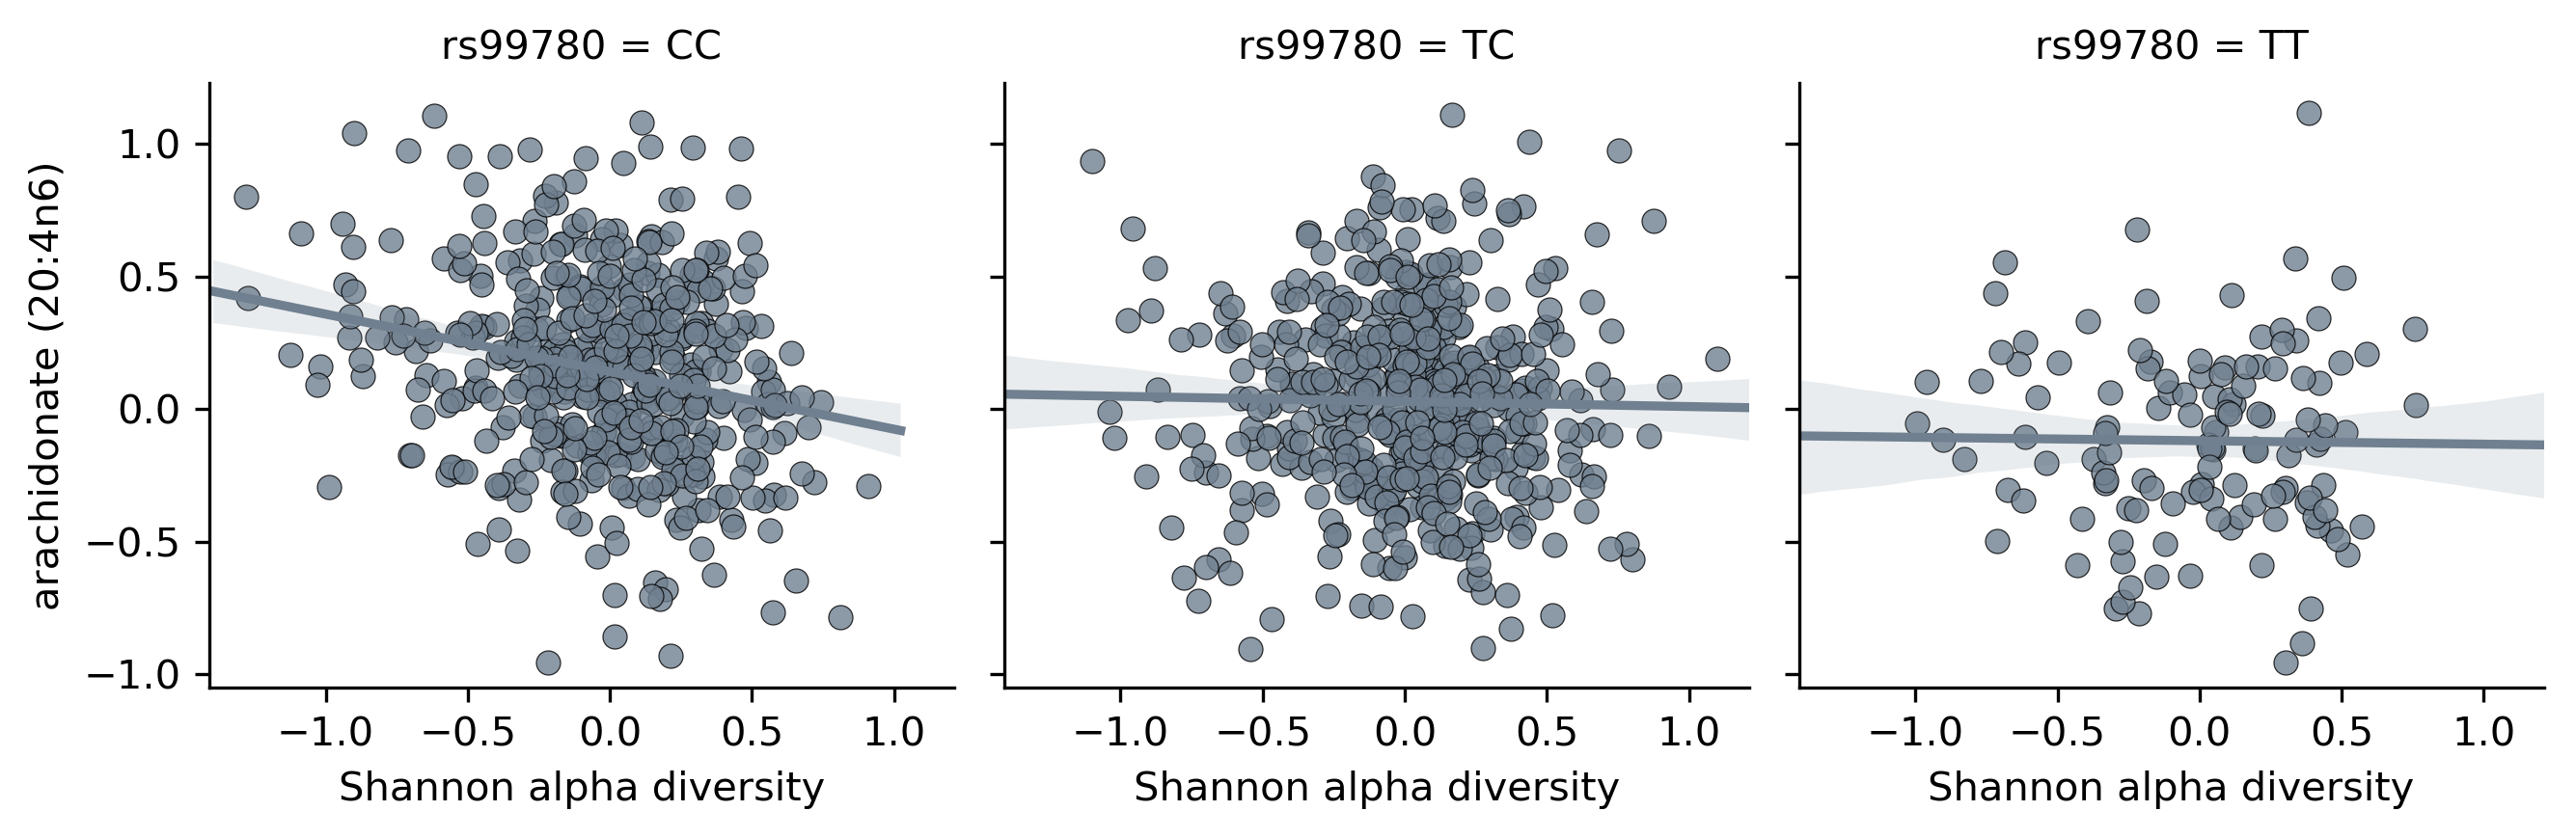

rs174564 1-palmitoyl-2-arachidonoyl-GPC (16:0/20:4n6) Shannon alpha diversity


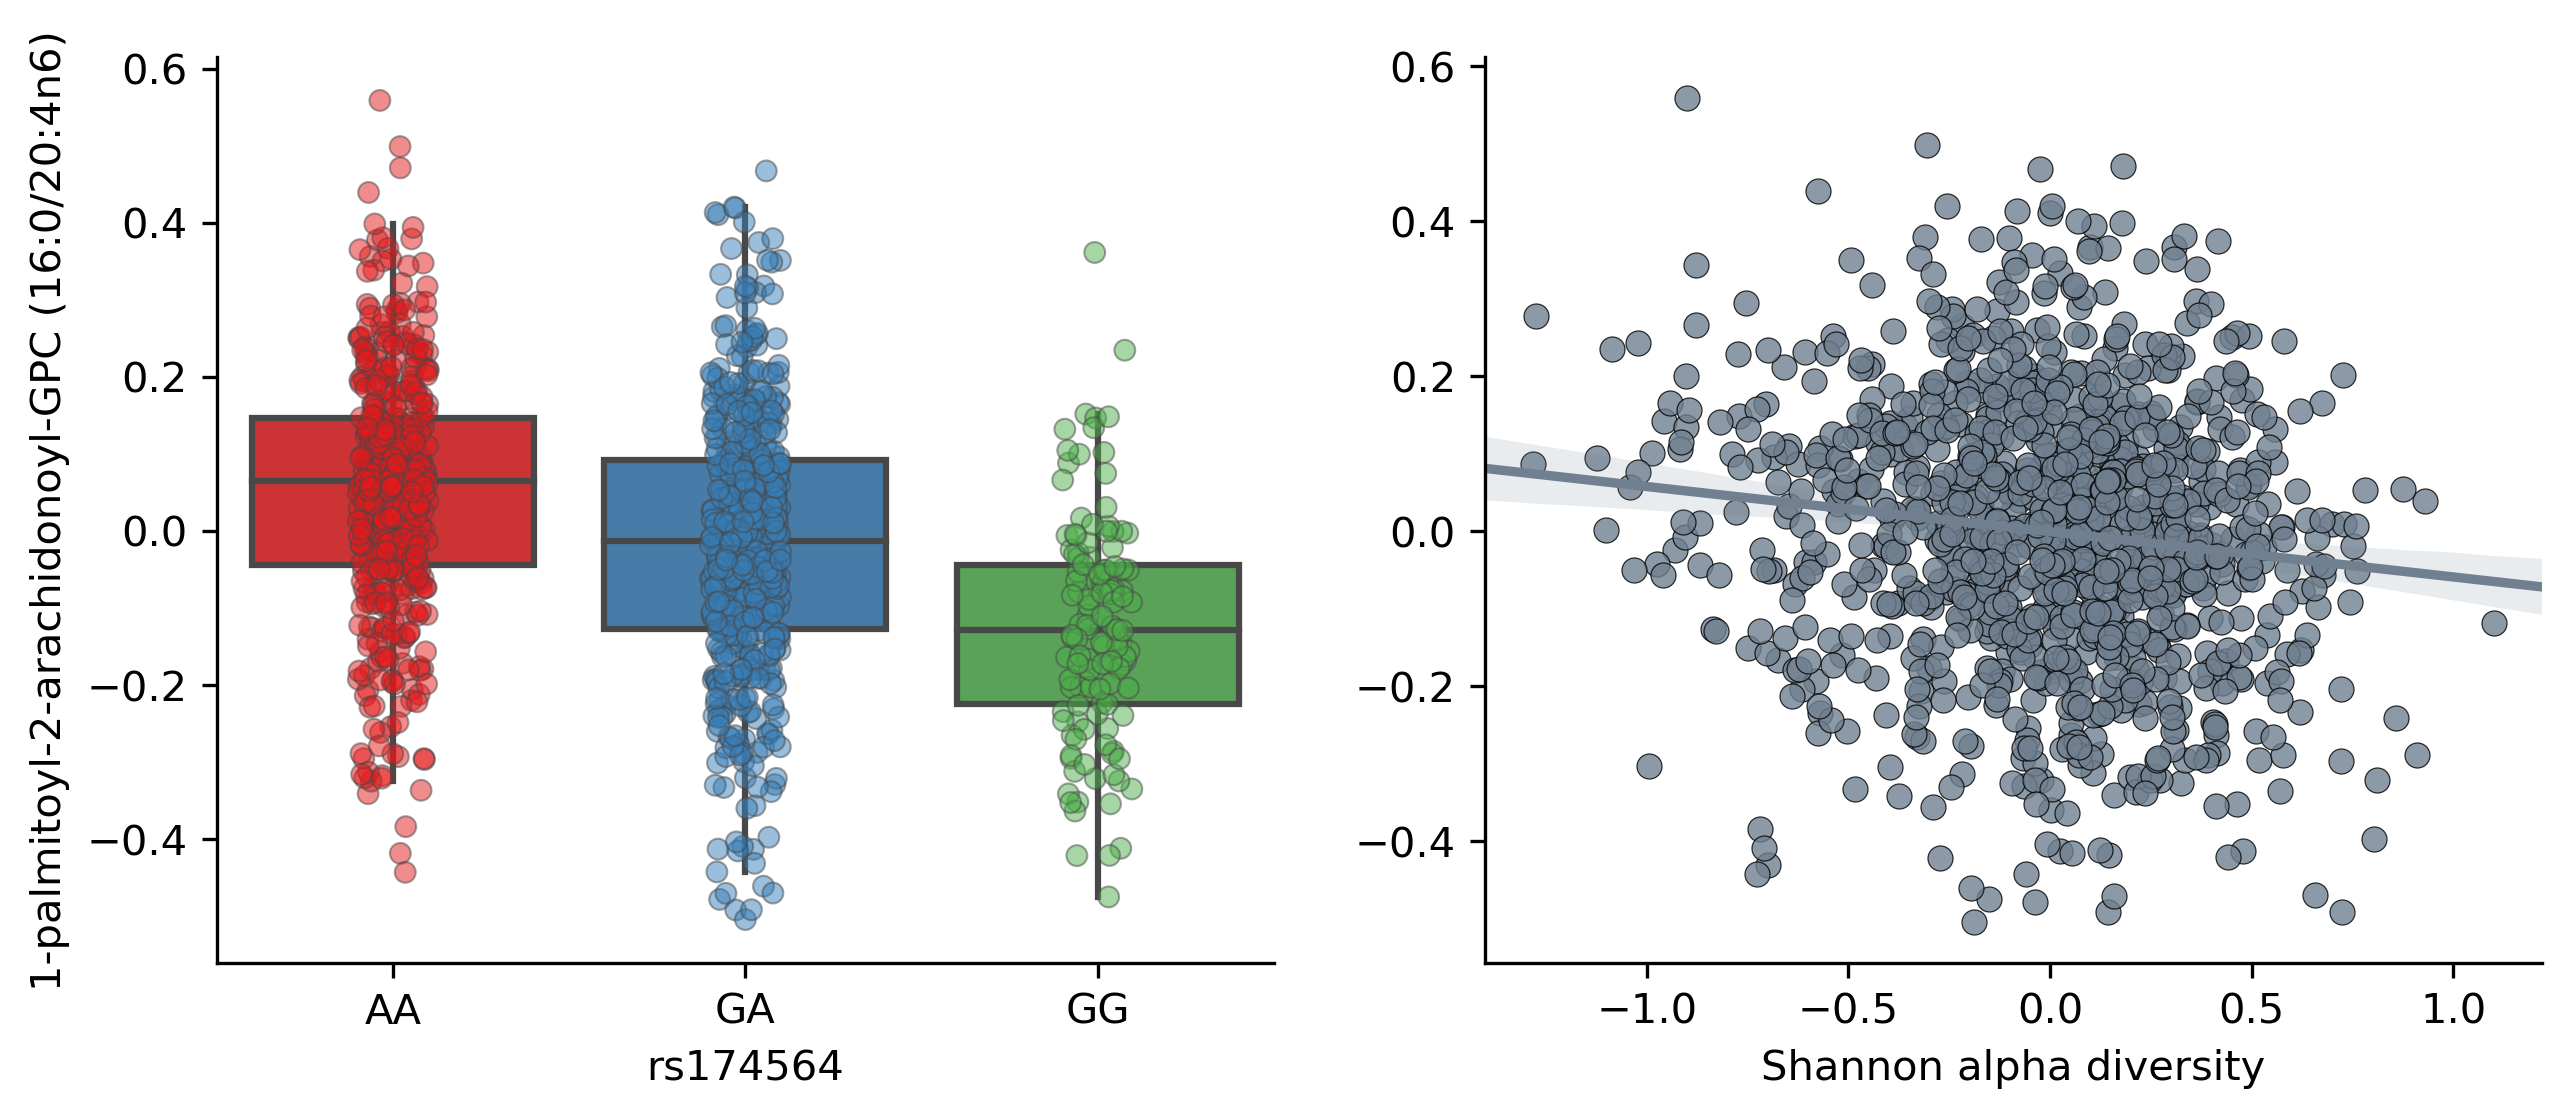

-0.12244330282557064
AA -0.21797733736169295 1.3906996013385322e-06
GA -0.03916533781506177 0.37555403417409183
GG -0.11262142789993303 0.2111247702138216


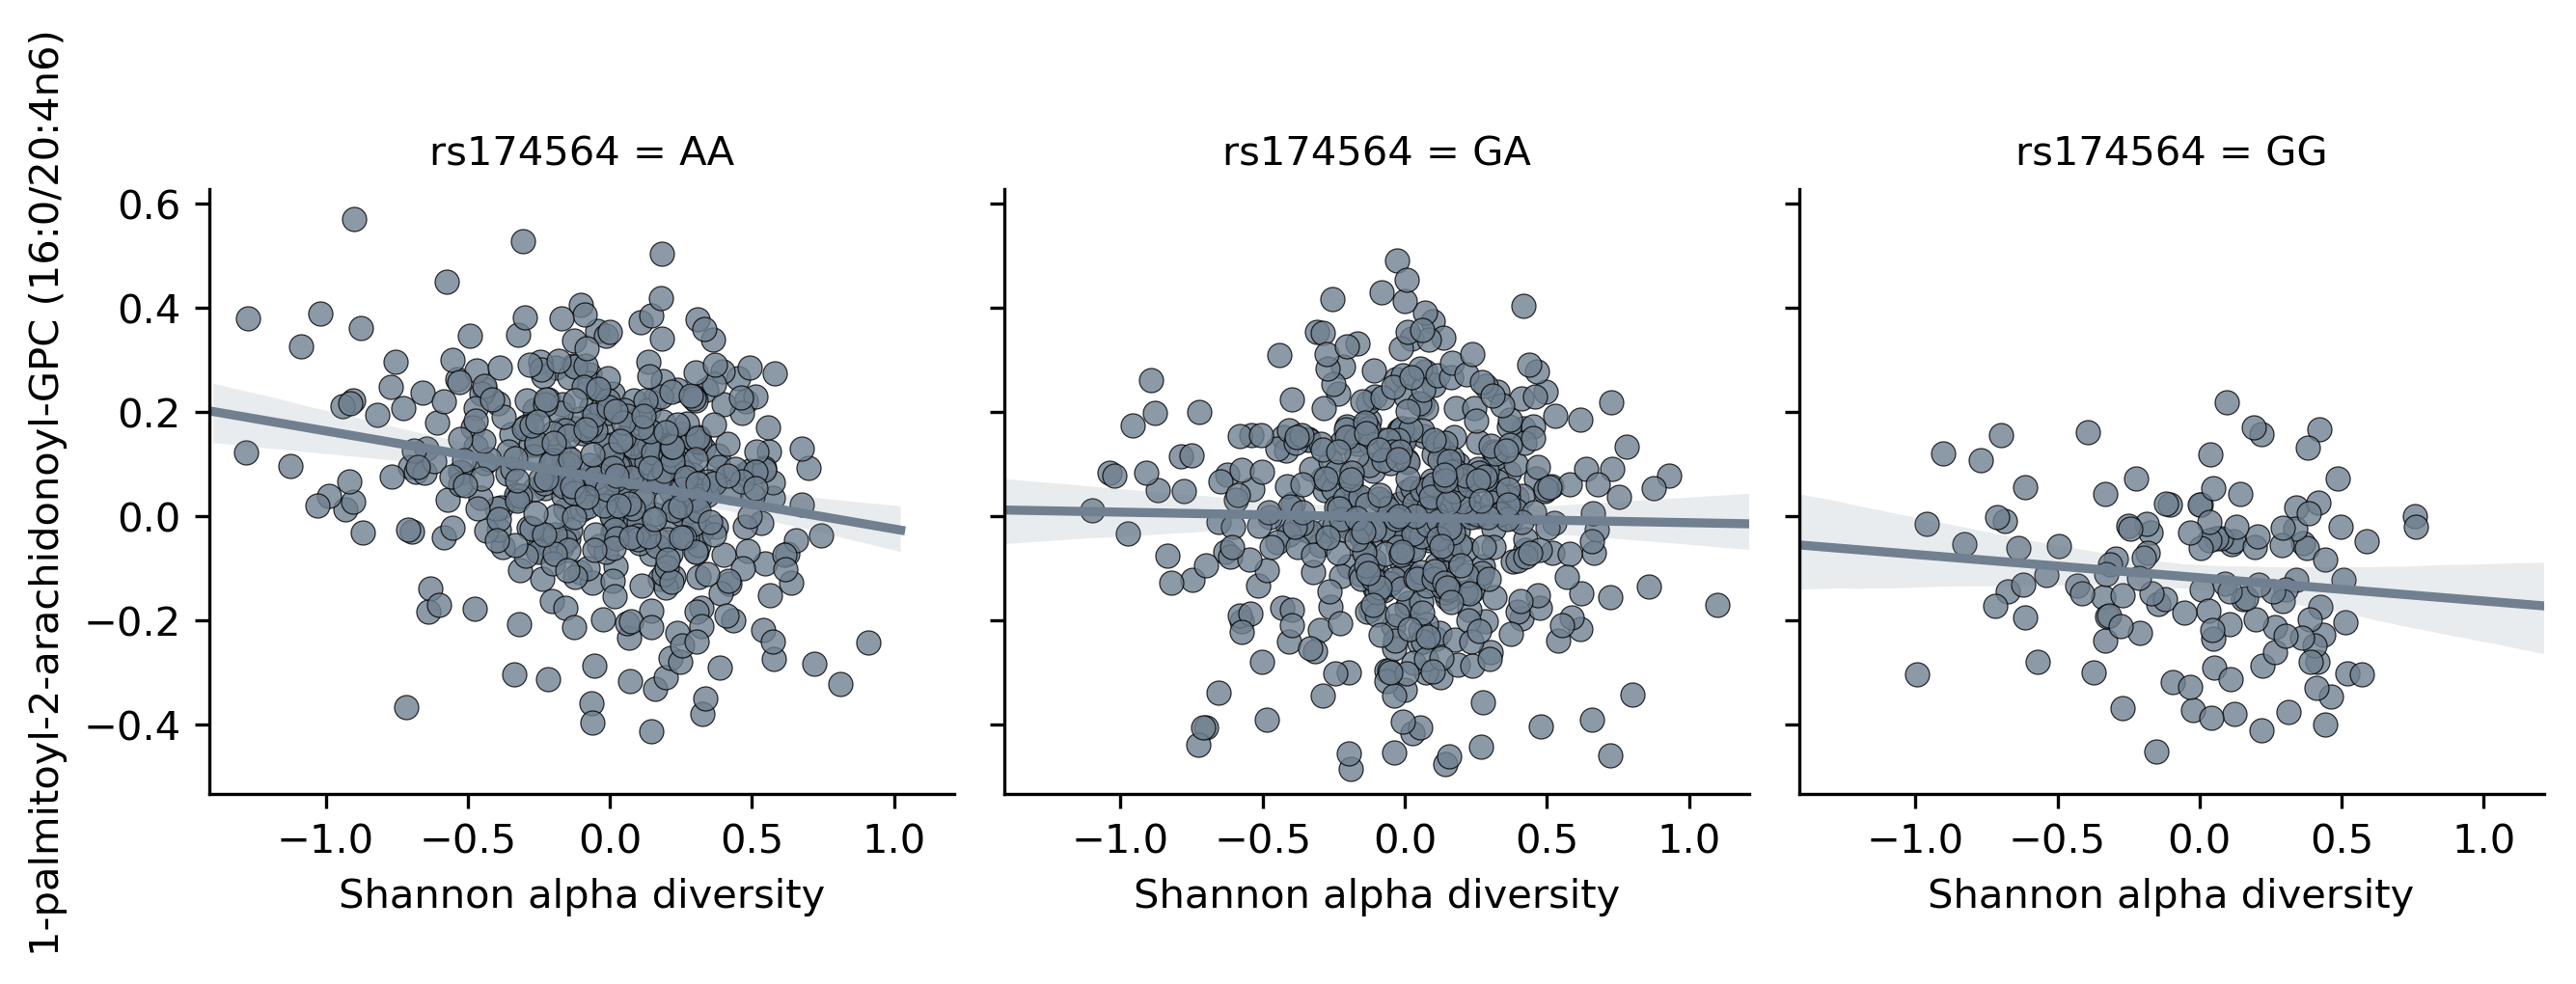

rs4149056 glycodeoxycholate 3-sulfate g__Clostridium sensu stricto


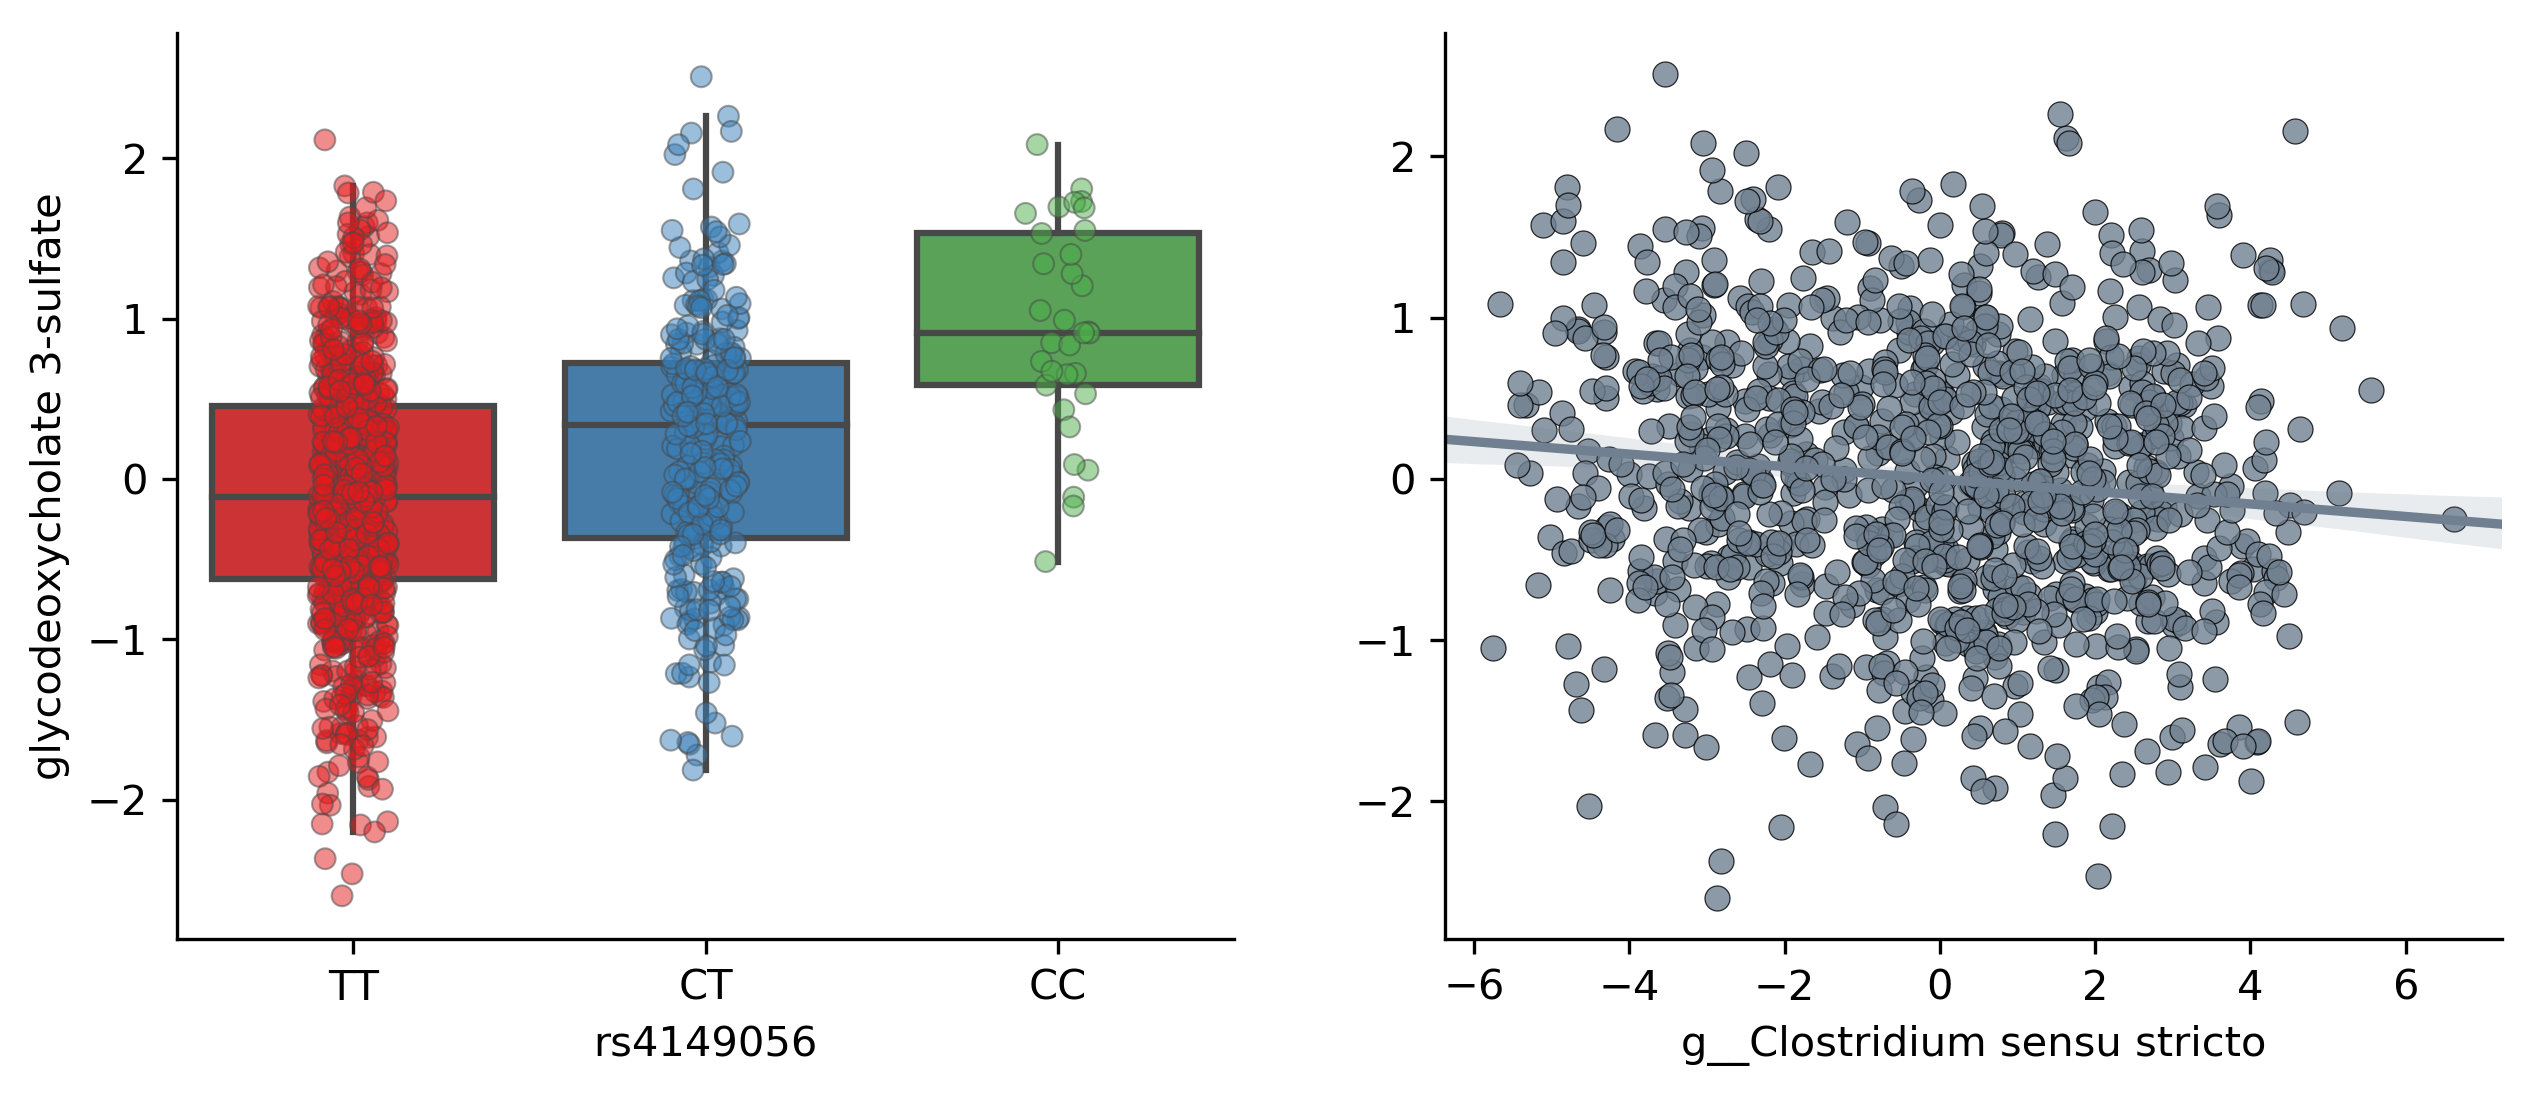

-0.11329290411546317
CC -0.28858378522520084 0.10337005477753082
CT -0.18989830124380228 0.001355447598999255
TT -0.07174619454495577 0.046854591540272474


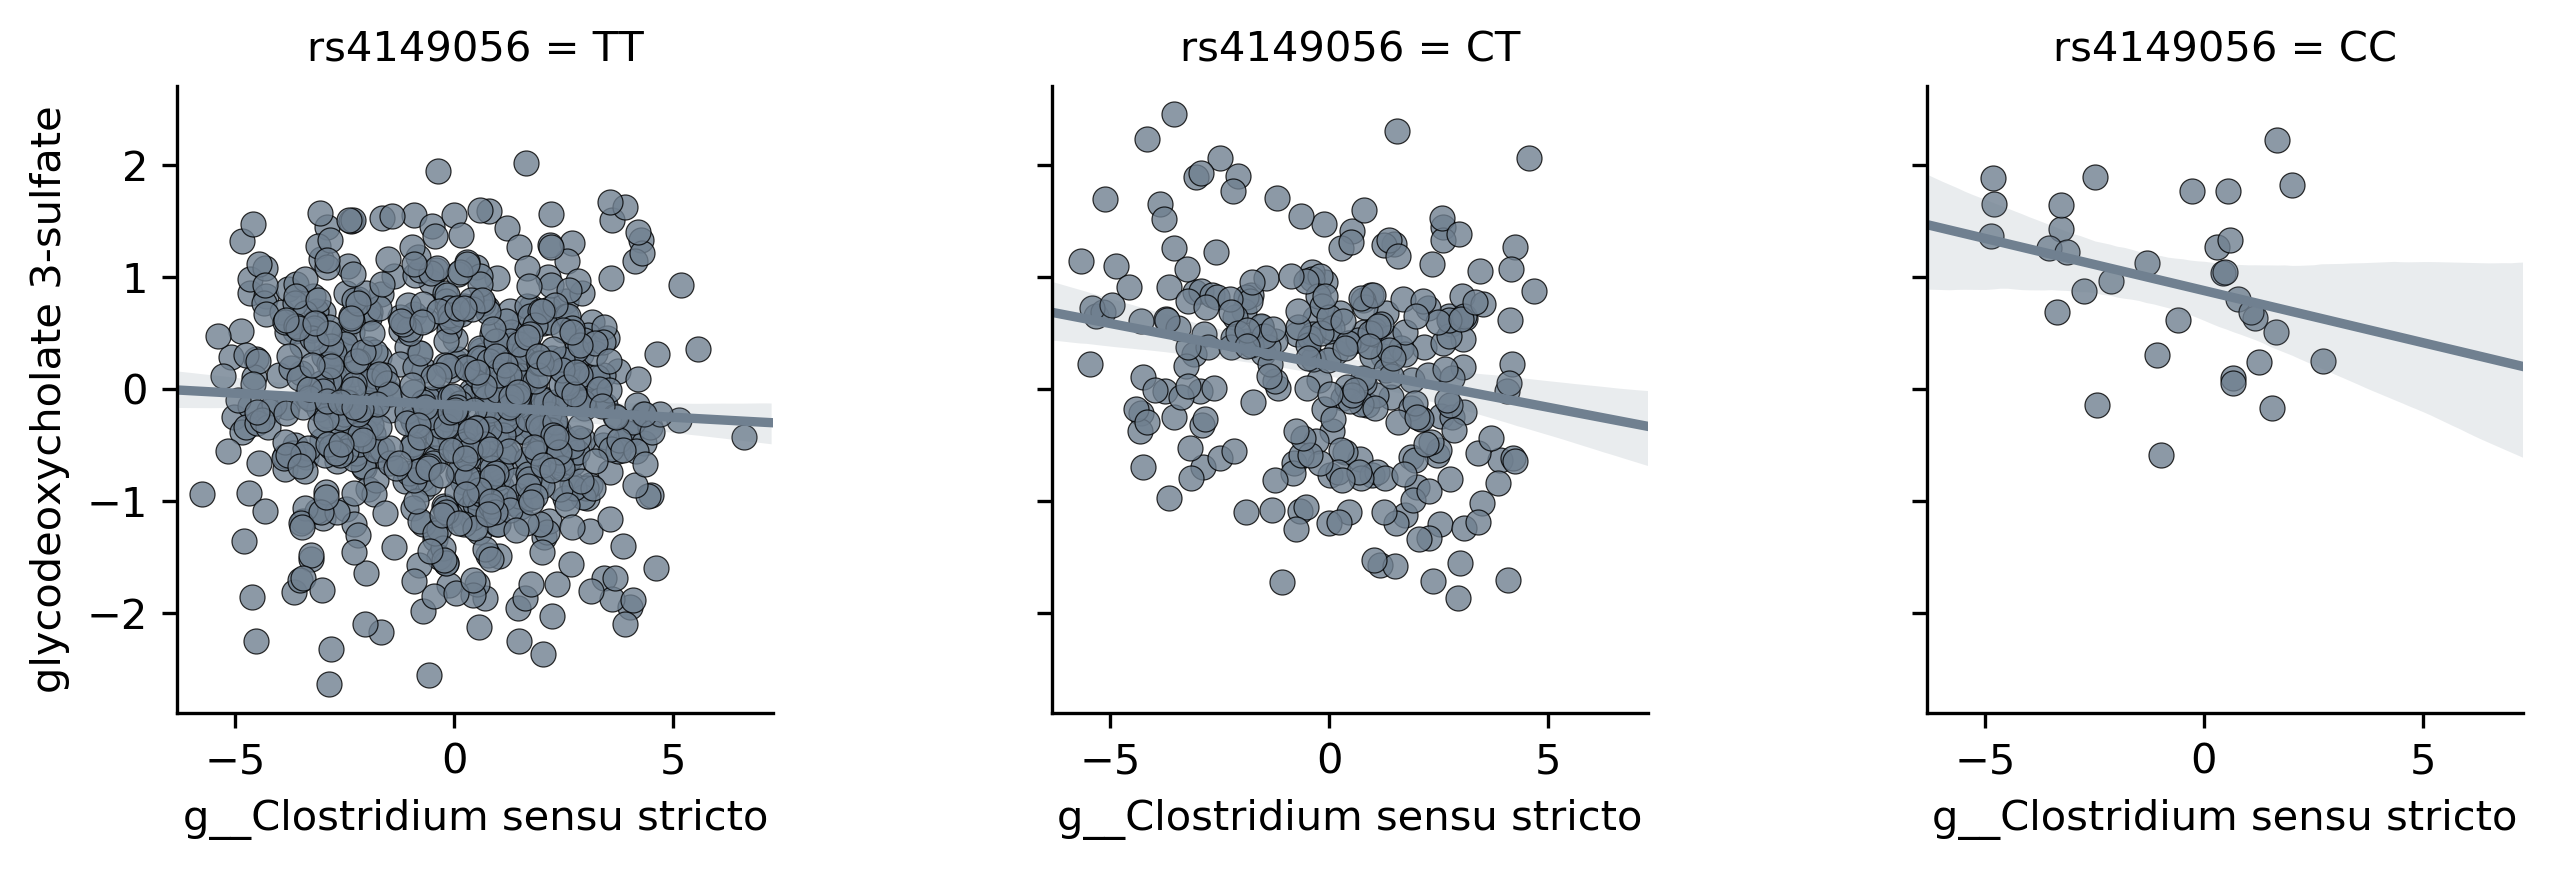

rs1077834 1-oleoyl-2-linoleoyl-GPE (18:1/18:2)* g__Anaerotruncus


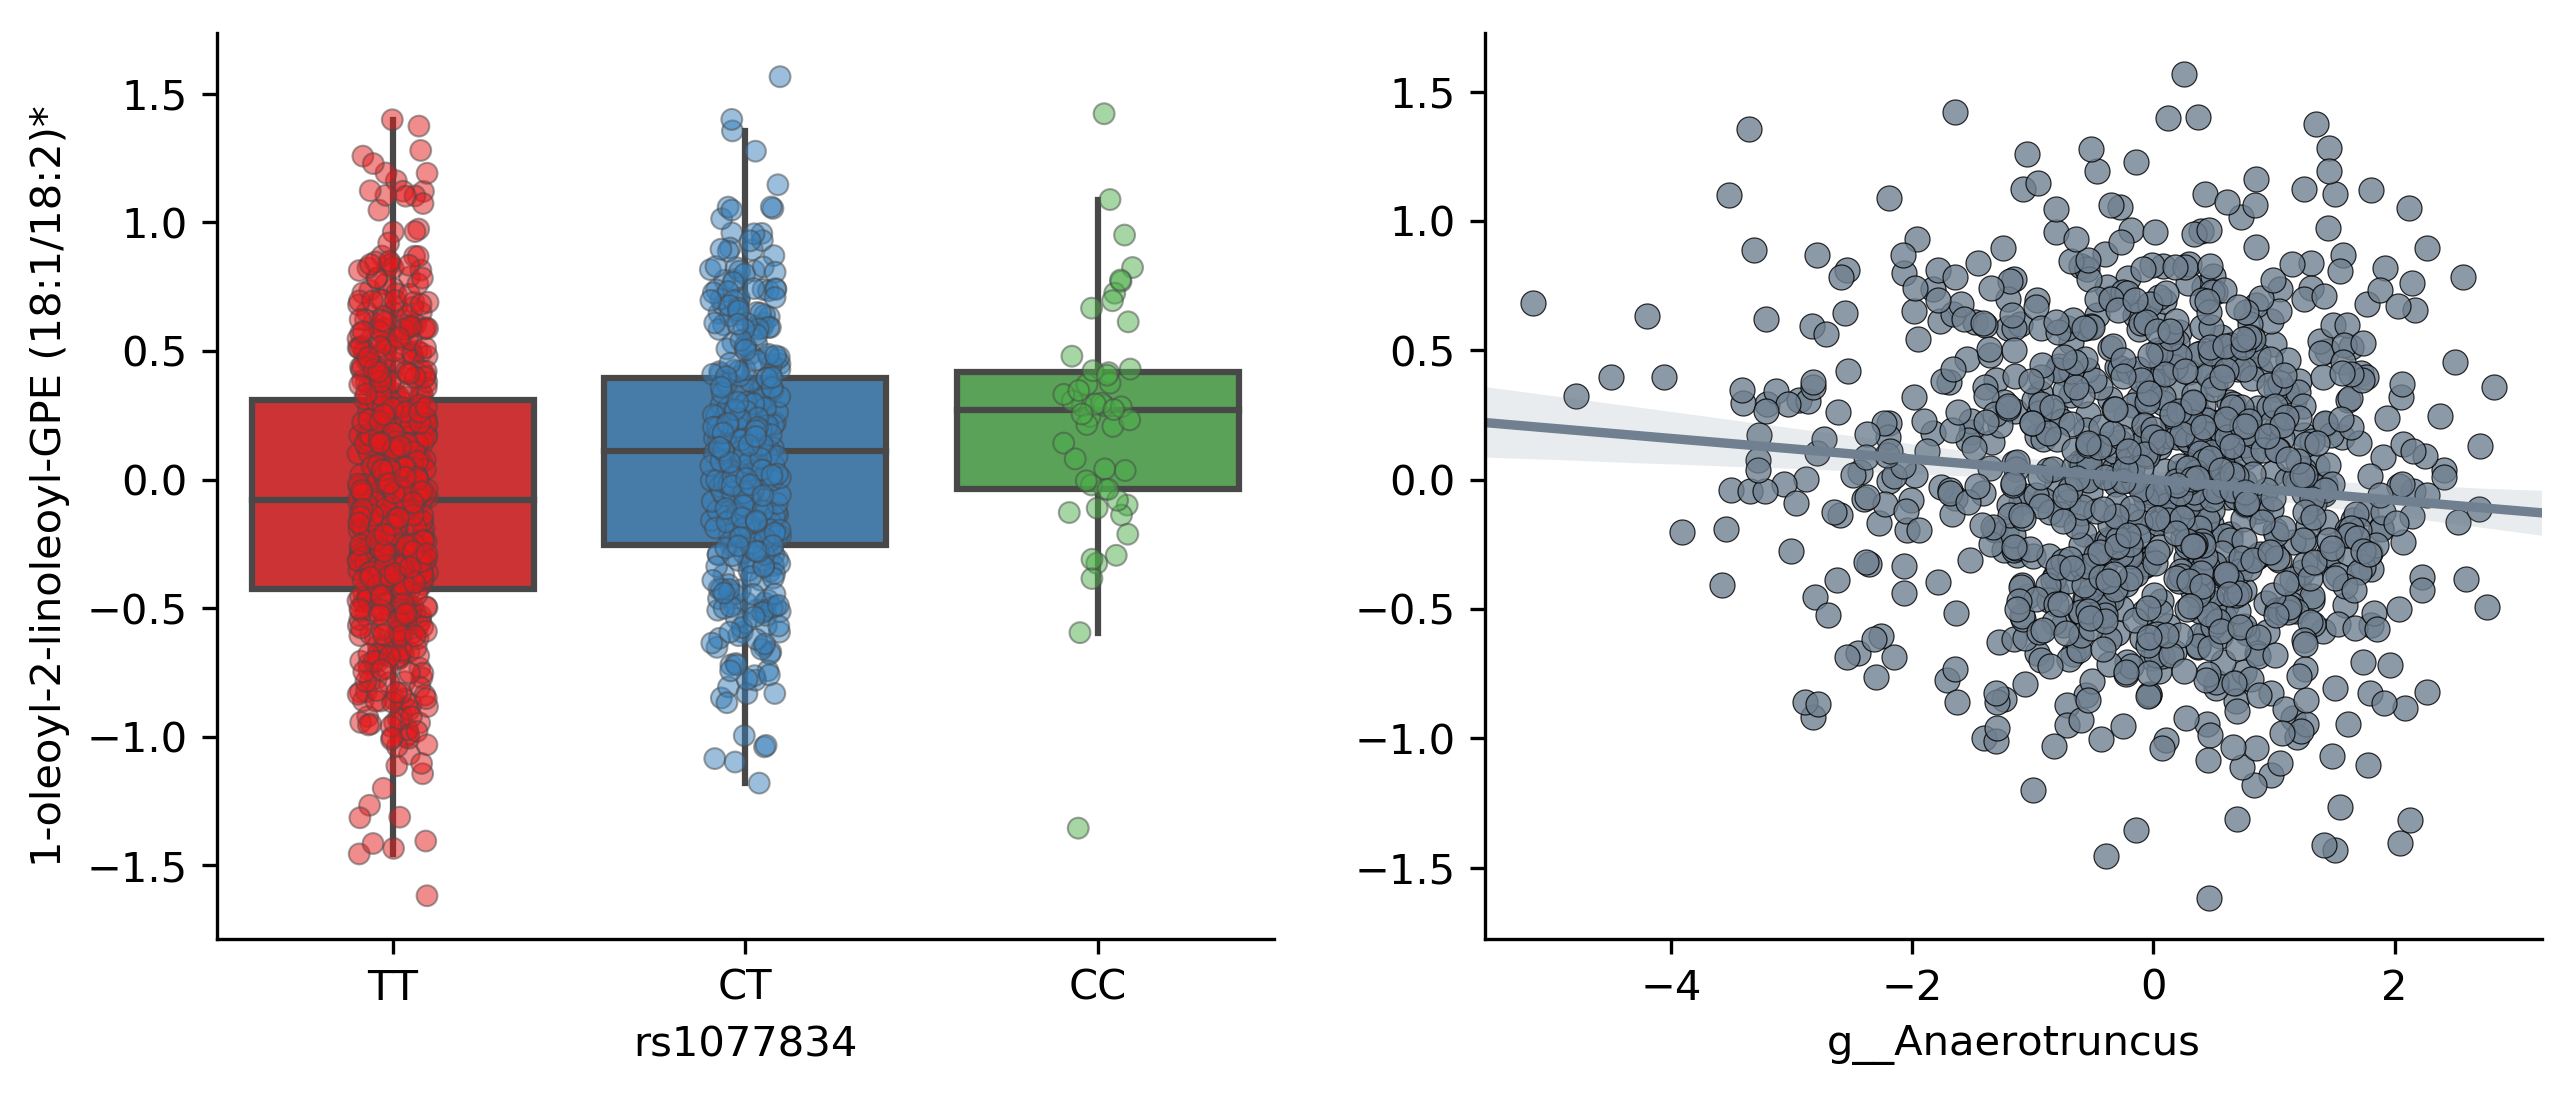

-0.09680831188242733
CC -0.2446412271438091 0.08359922432770257
CT -0.1907804834155635 0.00014747834144752356
TT -0.041008705446559754 0.30680443485569675


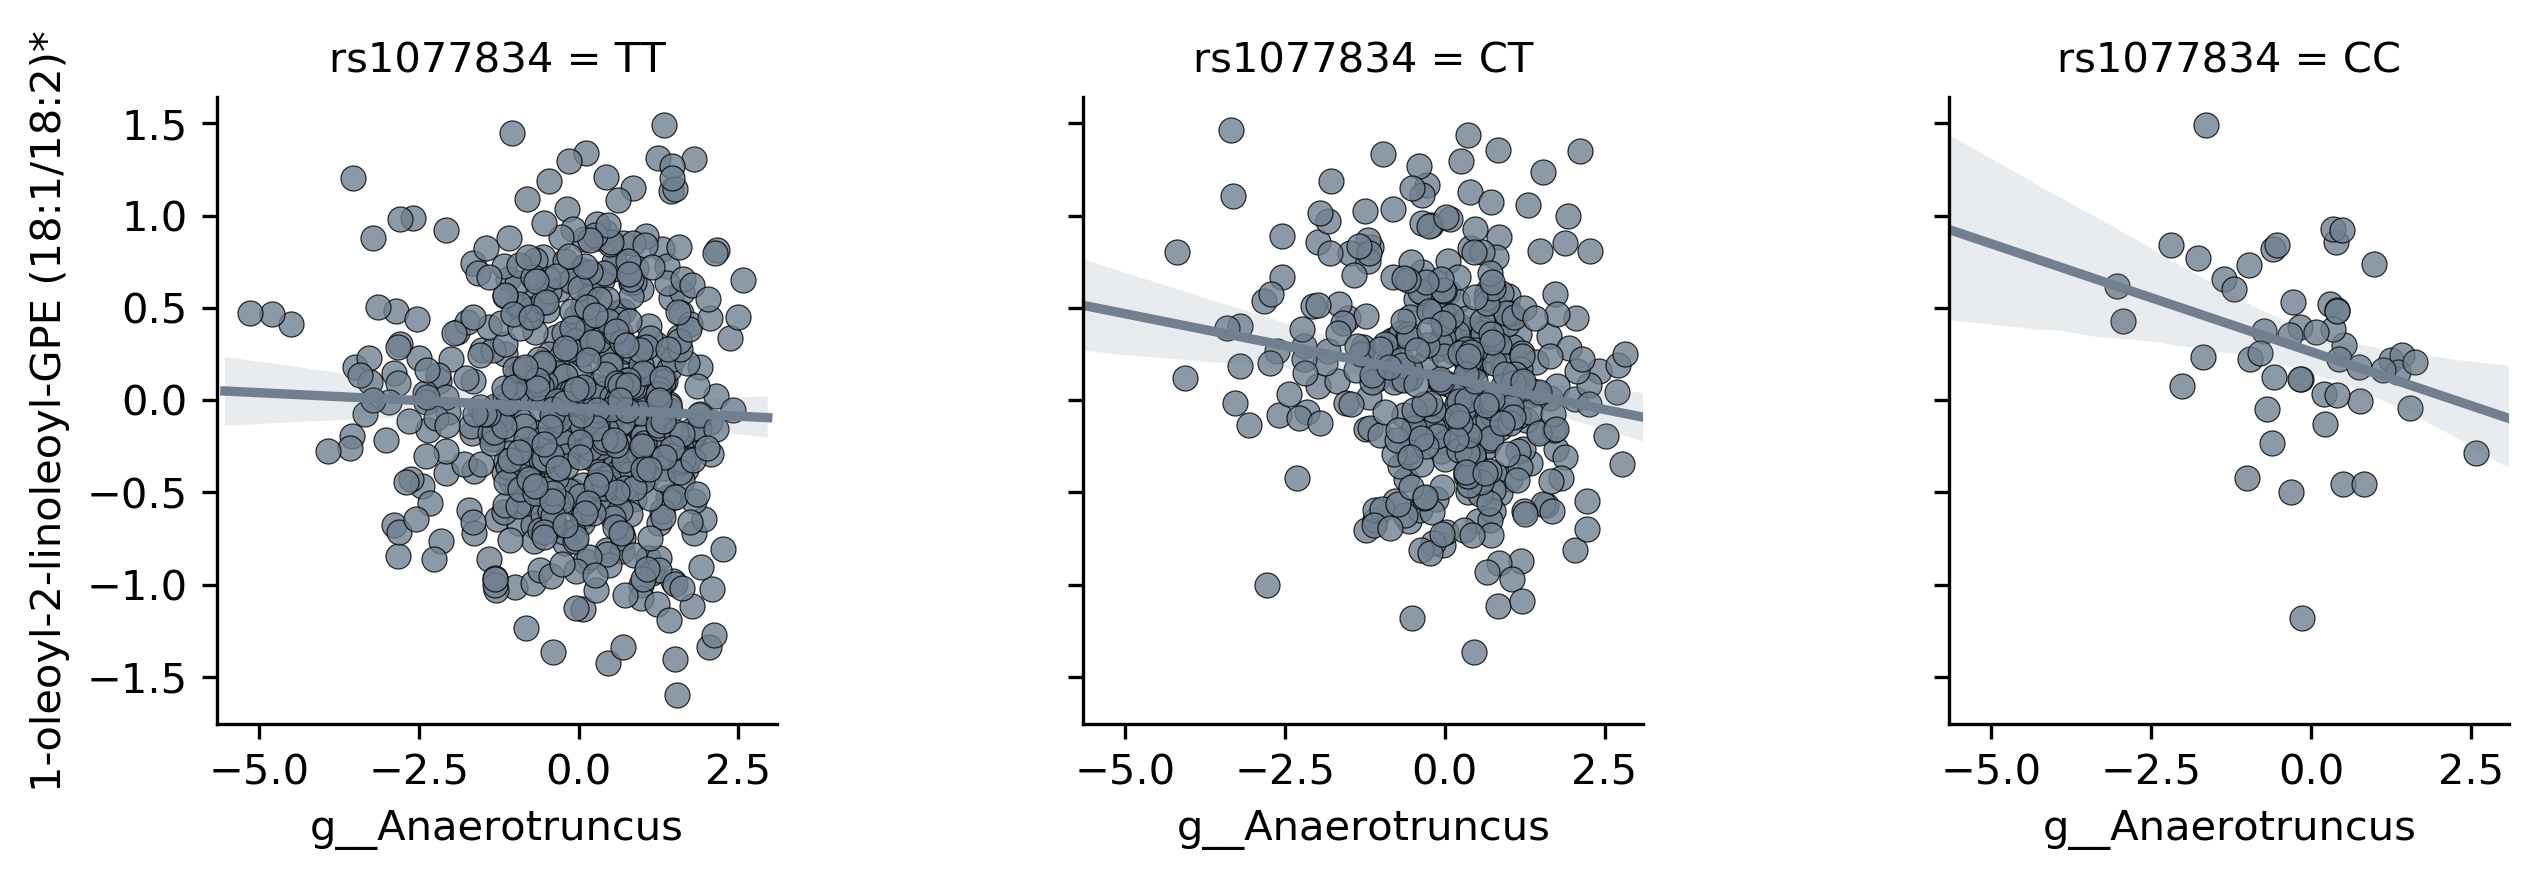

rs62492368 N-acetyl-isoputreanine g__Butyrivibrio


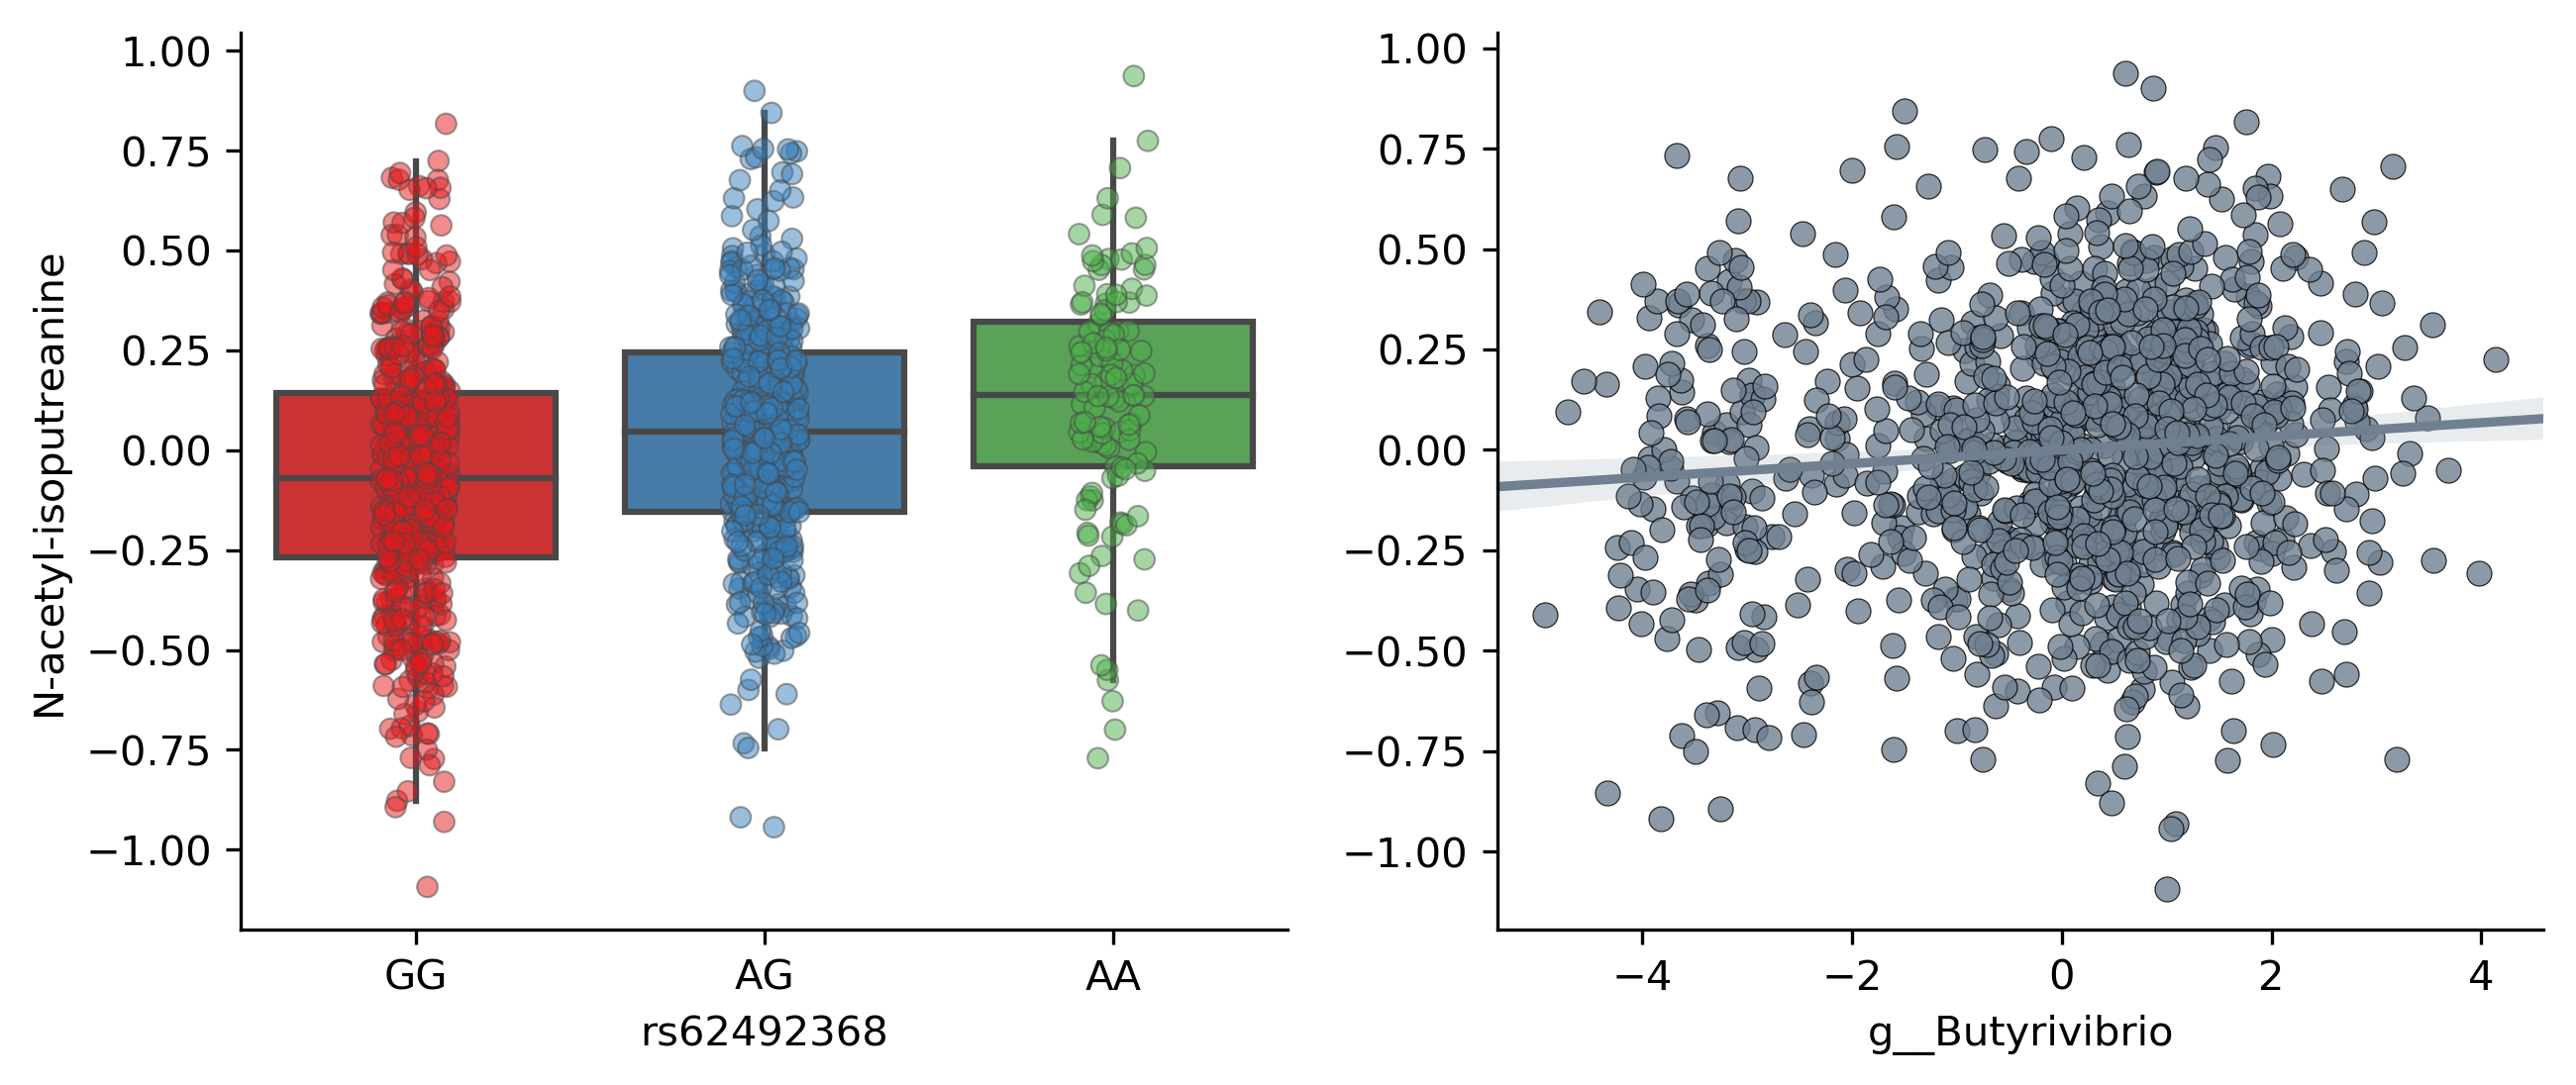

0.091764094757333
AA -0.04084840955442704 0.6577851057137174
AG 0.0588256719163867 0.19684409445895834
GG 0.15090647892655806 0.0004965655561380866


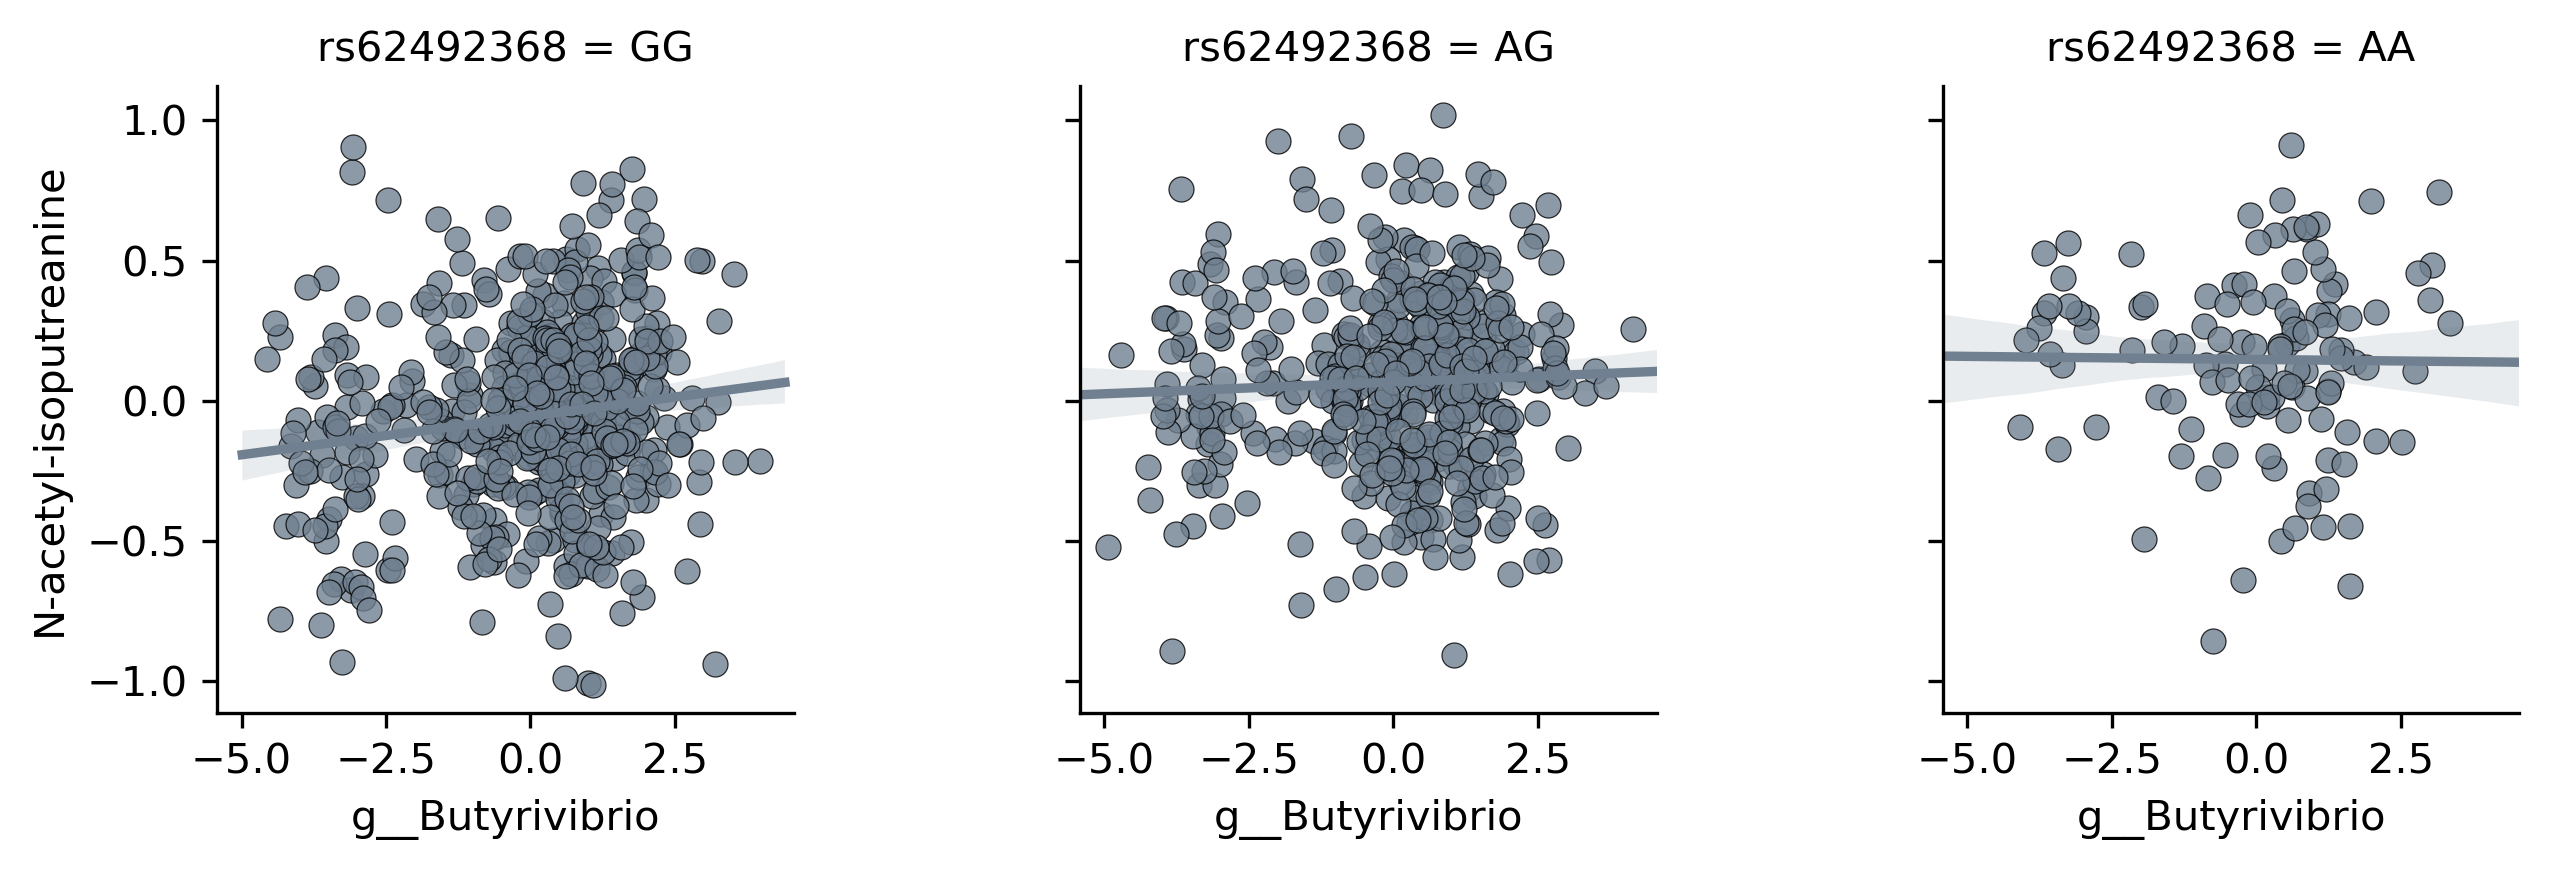

rs11045856 hexadecanedioate (C16-DC) g__Anaerovorax


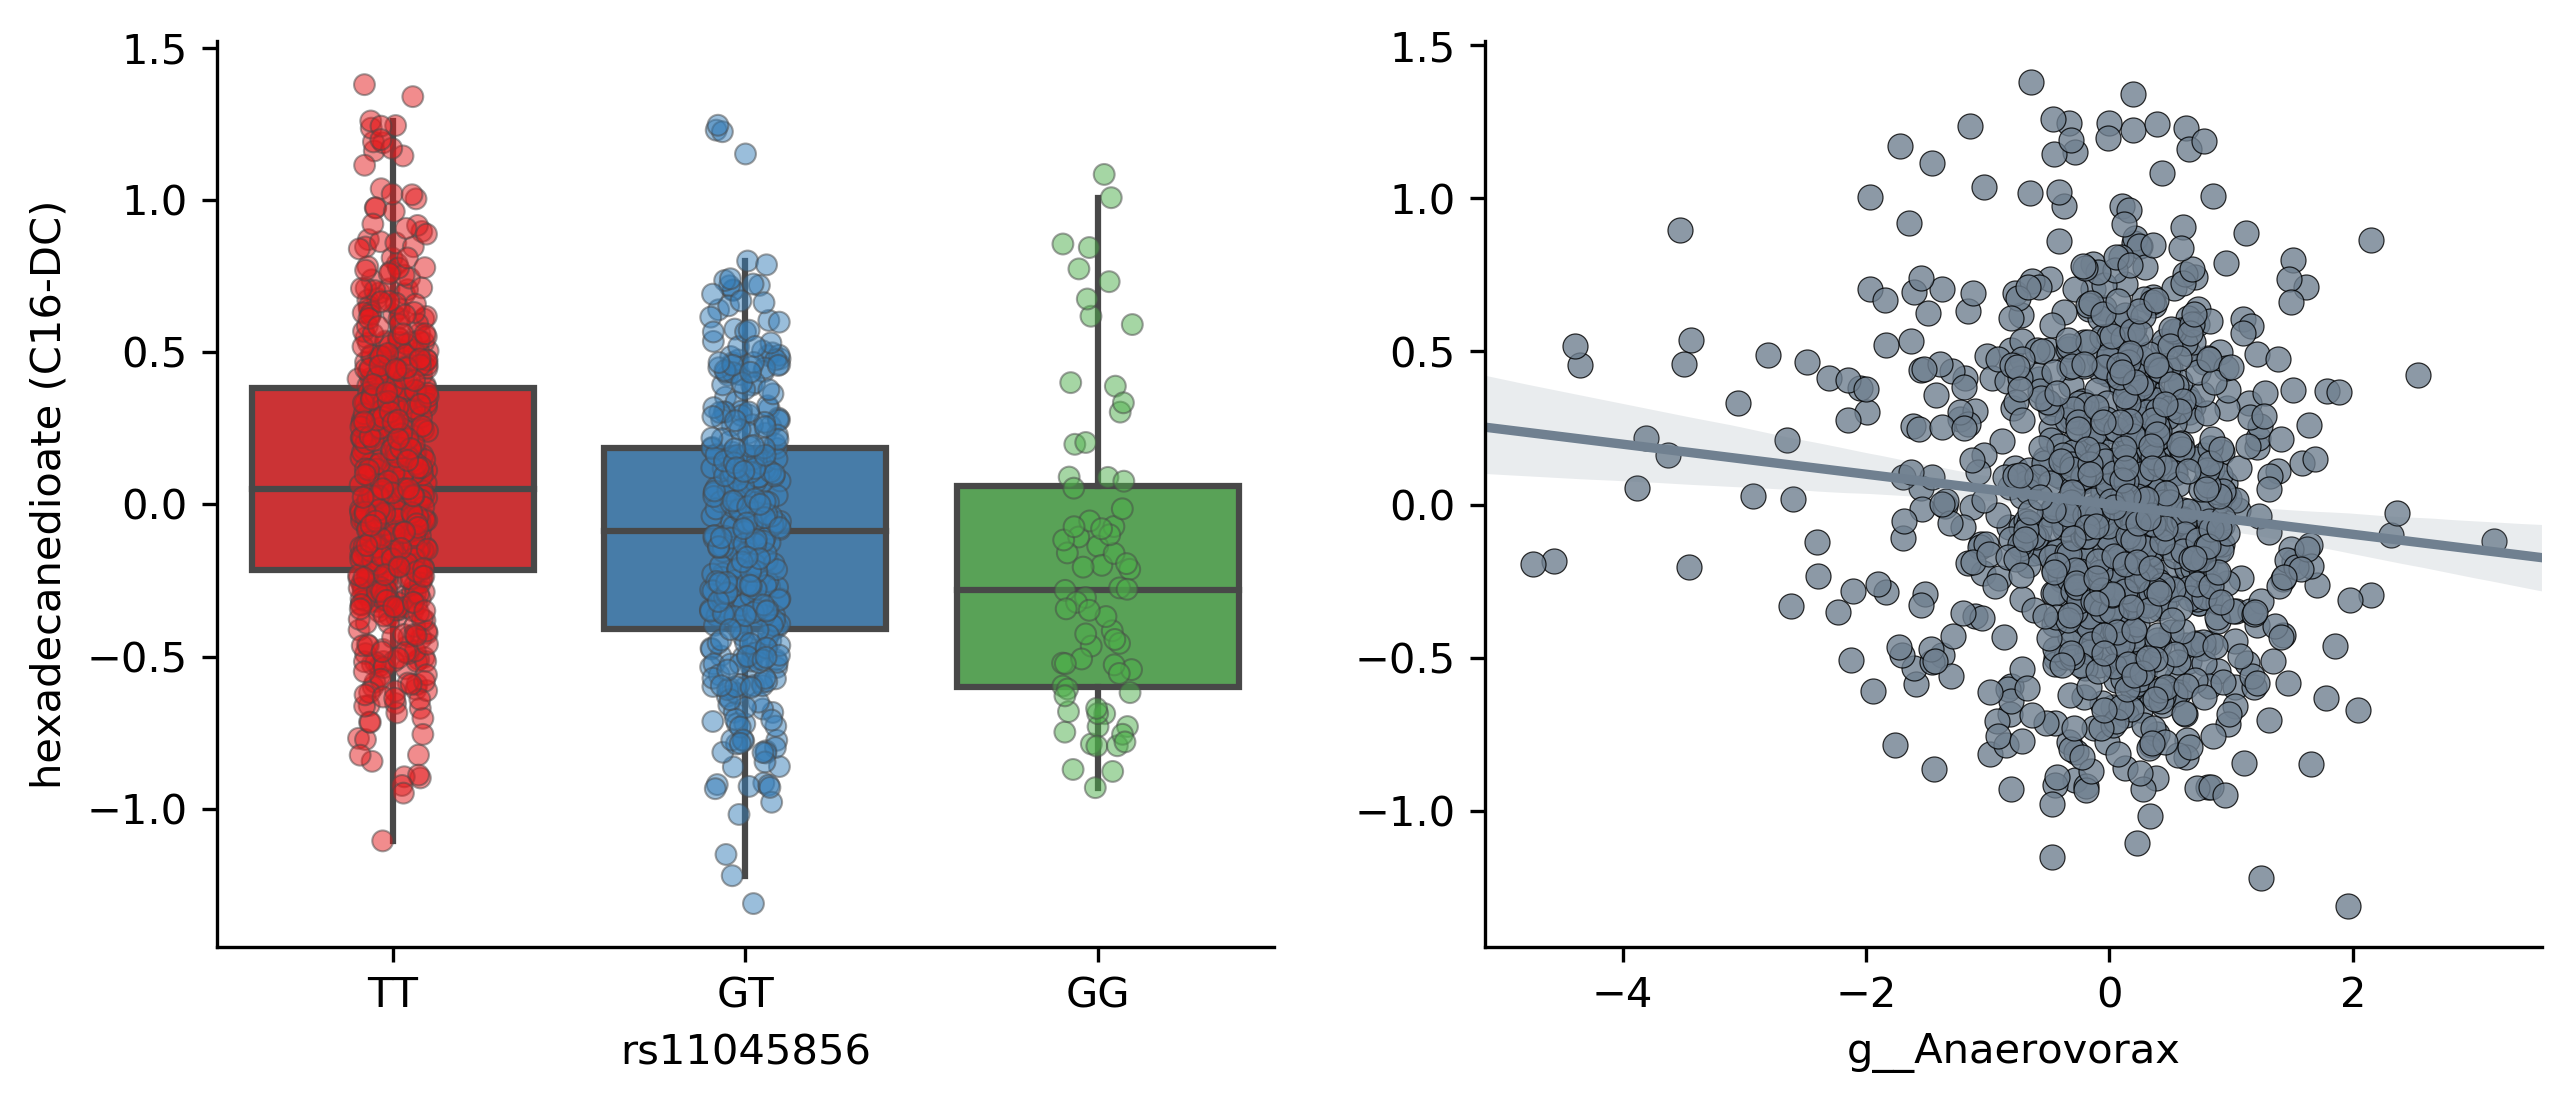

-0.09575021061401075
GG -0.08745874903472094 0.4650689869128386
GT -0.005240006949911507 0.9182672501516365
TT -0.17185390265587244 2.7510375505029116e-05


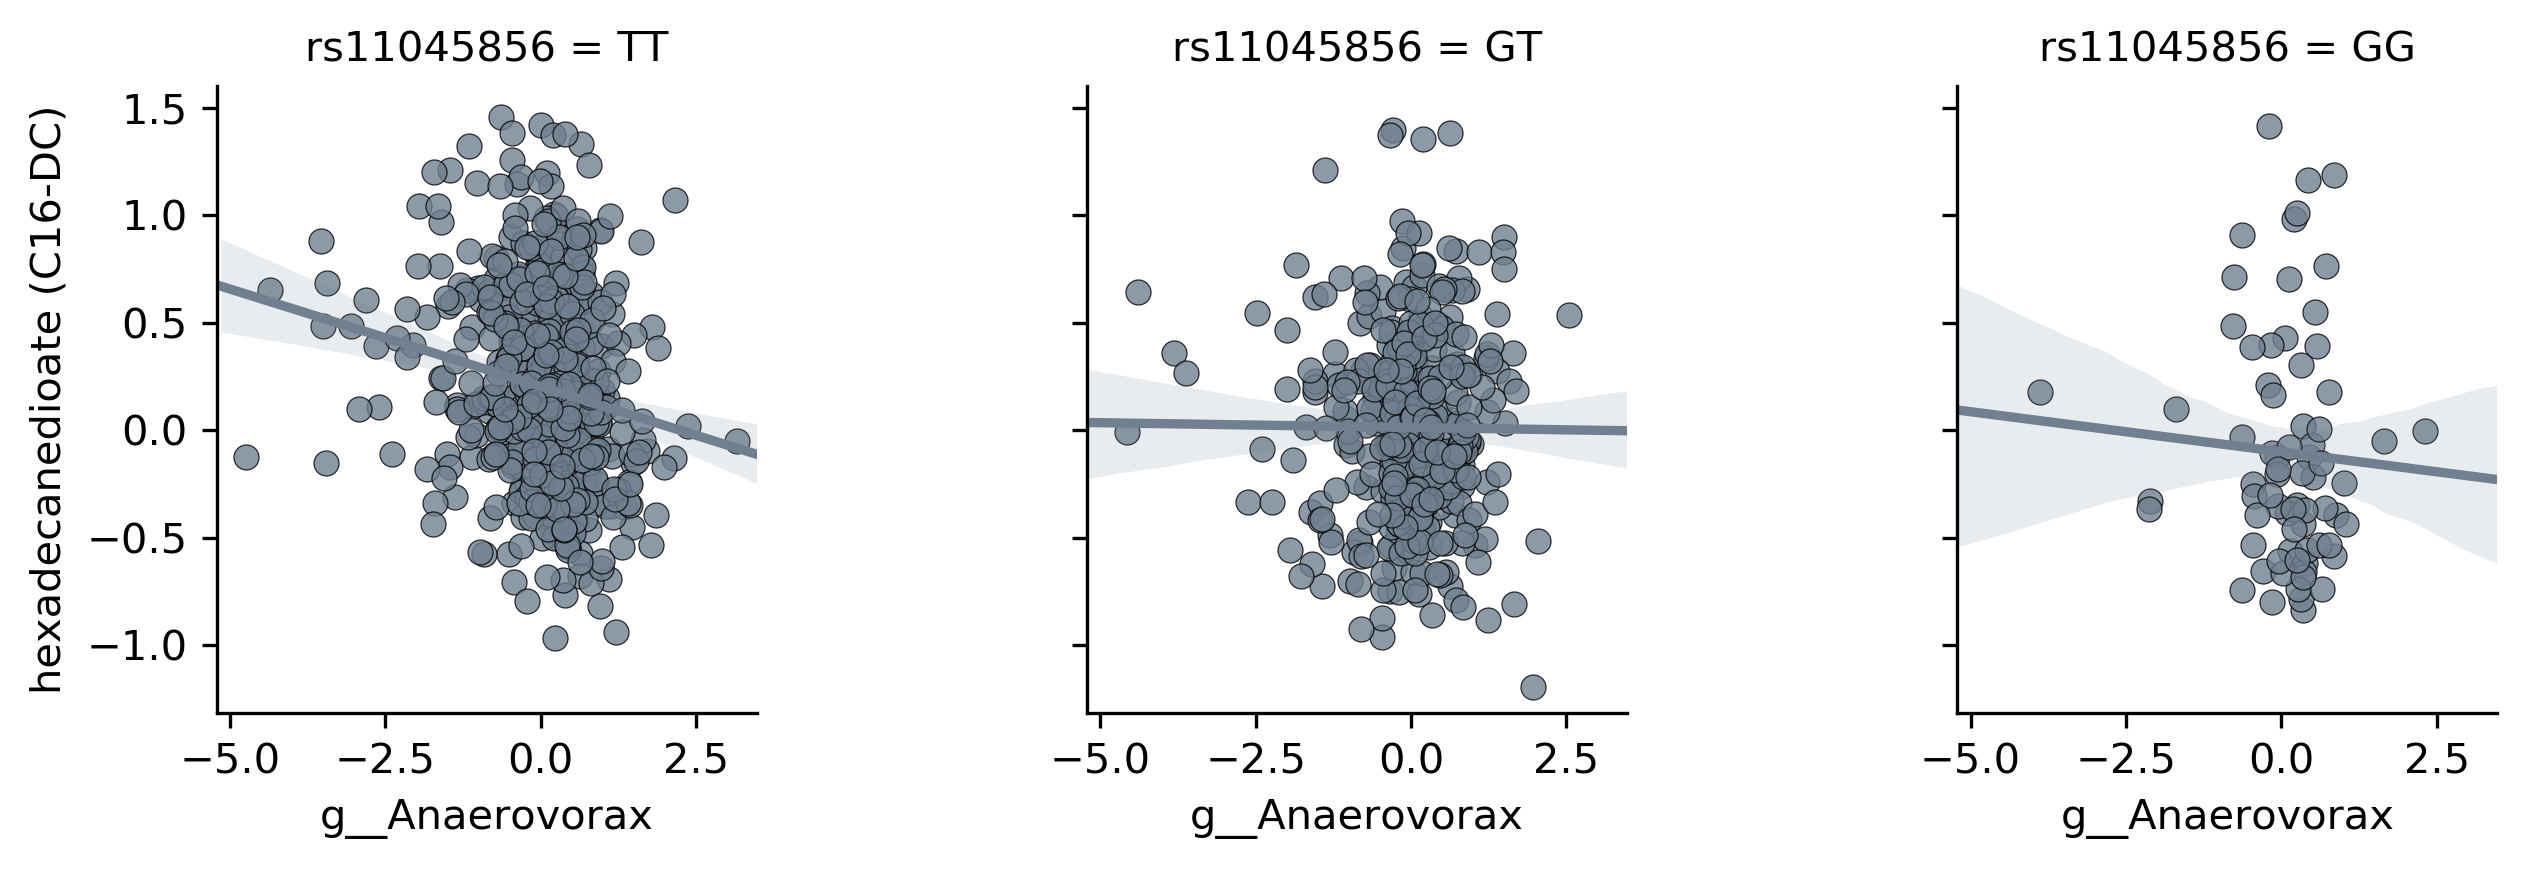

In [241]:
for i in temp_gxe_interest.index:
    hit = temp_gxe_interest.loc[i]
    sig_metab = hit['metabolite_id']
    sig_rsid = hit['rsid']
    sig_microbe = hit['tax_id']
    temp_hit_geno = pandas.DataFrame(genotype.get_acgt_geno_marker(sig_rsid), index = sample_ids, columns = [sig_rsid])
    temp_hit_geno = temp_hit_geno.join(pandas.DataFrame(genotype.get_geno_marker(sig_rsid), index = sample_ids, columns = [sig_rsid + '_alt_count']))
    temp_pheno_covar_merged = pheno_covar_merged[[sig_metab, sig_microbe] + covariates].join(temp_hit_geno, how = 'inner').dropna()

    bim = genotype.get_bim()
    hit_minor_allele = bim.loc[sig_rsid, 'a1']
    hit_major_allele = bim.loc[sig_rsid, 'a2']
    allele_order = [hit_major_allele*2, hit_minor_allele + hit_major_allele, hit_minor_allele*2]

    temp_cov_adj_formula = sig_metab + ' ~ ' + ' + '.join(form_covar + rename_c_covar)
    temp_cov_adj_lm = ols(temp_cov_adj_formula, temp_pheno_covar_merged).fit()
    temp_pheno_covar_merged['covar_adj'] = temp_cov_adj_lm.resid

    print(sig_rsid, metabolite_metadata_dict[sig_metab], genus_metadata_dict[sig_microbe])

    scatter_args = {'linewidth':0.3, 'edgecolor':'black', 'color':'slategrey'}
    line_args = {'color':'slategrey'}
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize = (10,4), sharey= False)
    sns.boxplot(x = sig_rsid, y= 'covar_adj', data = temp_pheno_covar_merged, 
                order = allele_order, ax = ax1, palette = 'Set1', showfliers = False, showcaps = False)
    sns.stripplot(x = sig_rsid, y= 'covar_adj', data = temp_pheno_covar_merged, 
                  order = allele_order, ax = ax1, palette = 'Set1', linewidth=0.5, alpha = 0.5)
    sns.regplot(x = sig_microbe, y = 'covar_adj', data = temp_pheno_covar_merged,
                scatter_kws = scatter_args, ax = ax2,
               line_kws = line_args)
    ax1.set_ylabel(metabolite_metadata_dict[sig_metab])
    ax2.set_ylabel('')
    ax2.set_xlabel(genus_metadata_dict[sig_microbe])
    sns.despine()
    plt.show()
    plt.close()
    
    print(scipy.stats.pearsonr(temp_pheno_covar_merged['covar_adj'], temp_pheno_covar_merged[sig_microbe])[0])
    for index, (protein_genotype, subset_df) in enumerate(temp_pheno_covar_merged.groupby(sig_rsid)):
        slope, intercept, r, pval, std = scipy.stats.linregress(subset_df['covar_adj'], subset_df[sig_microbe])
        print(protein_genotype, r, pval)
    
    g = sns.FacetGrid(data=temp_pheno_covar_merged, col=sig_rsid, col_order = allele_order)
    g.map(sns.regplot, sig_microbe, sig_metab,  scatter_kws = scatter_args, line_kws = line_args)
    g.set(xlim=(temp_pheno_covar_merged[sig_microbe].min()*1.1, temp_pheno_covar_merged[sig_microbe].max()*1.1),
         ylim=(temp_pheno_covar_merged[sig_metab].min()*1.1, temp_pheno_covar_merged[sig_metab].max()*1.1))
    g.set_xlabels(genus_metadata_dict[sig_microbe])
    g.set_ylabels(metabolite_metadata_dict[sig_metab])
    plt.show()
    plt.close()

0.595426733459105
0.43047902136285554


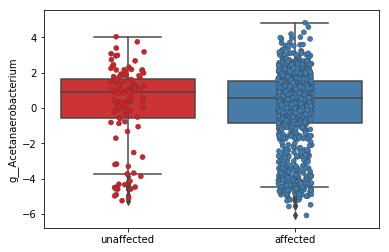

In [13]:
temp_pheno_covar_merged['affected'] = [1 if i.count(hit_minor_allele) > 0 
                                       else 0 
                                       for i in temp_pheno_covar_merged[sig_rsid]]
affected_order = [0, 1]
affected_x_tick_label = list(map({0:'unaffected', 1:'affected'}.get, affected_order))

print(ols('{0} ~ {1}'.format(sig_microbe,'affected'), data=temp_pheno_covar_merged).fit().pvalues['affected'])
print(ols('{0} ~ {1}'.format(sig_microbe,sig_rsid+'_alt_count'), data=temp_pheno_covar_merged).fit().pvalues[sig_rsid+'_alt_count'])


fig, ax = plt.subplots()
sns.boxplot(x = 'affected', y= sig_microbe, data = temp_pheno_covar_merged, order = [0, 1], ax = ax, palette = 'Set1')
sns.stripplot(x = 'affected', y= sig_microbe, data = temp_pheno_covar_merged, order = [0, 1], ax = ax, palette = 'Set1', linewidth=0.5)
ax.set_xticklabels(affected_x_tick_label)
ax.set_xlabel('')
ax.set_ylabel(genus_metadata_dict[sig_microbe])
plt.show()
plt.close()

In [14]:
R.r('library(MASS)')
R.r('library(ppcor)')
R.r.assign('temp_pheno_covar_merged',temp_pheno_covar_merged)


R.r('pcor.test(temp_pheno_covar_merged${0}, temp_pheno_covar_merged${1}, temp_pheno_covar_merged${2})'.format(sig_rsid+'_alt_count',
                                                                                                                               'covar_adj',
                                                                                                                               sig_microbe))

/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in library(ppcor) : there is no package called ‘ppcor’

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Error in library(ppcor) : there is no package called ‘ppcor’


In [20]:
R.r('pcor.test(temp_pheno_covar_merged${0}, temp_pheno_covar_merged${1}, temp_pheno_covar_merged${2})'.format(sig_microbe,
                                                                                                              'covar_adj',
                                                                                                             sig_rsid+'_alt_count',))

estimate   p.value  statistic    n   gp   Method
1  0.150638  0.000335   3.609117  564  1.0  pearson

In [21]:
R.r('pcor.test(temp_pheno_covar_merged${0}, temp_pheno_covar_merged${1}, temp_pheno_covar_merged${2})'.format(sig_rsid+'_alt_count',
                                                                                                                               sig_microbe,
                                                                                                                               'covar_adj'))


estimate   p.value  statistic    n   gp   Method
1 -0.002155  0.959318  -0.051033  564  1.0  pearson

In [22]:
temp_pheno_covar_merged.groupby(sig_rsid+'_alt_count').count()[sig_microbe]/len(temp_pheno_covar_merged)

rs422137_alt_count
0    0.326241
1    0.469858
2    0.203901
Name: X00cb26a6f99c316ce83871225fe34fff, dtype: float64